# Making and Testing Dips 

In this notebook, we're going to simulate some dips

In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import numpy as np
import pandas as pd

import lightkurve as lk
from dipper import measure_dip

Kyle has a basic function in his notebook that I think we can extend:

In [3]:
def simulate_dip_flux(tseg=20, coverage=3.0, width=5, depth=0.2, tdip=None):
    """
    Simulate normalized flux for one or multiple dips on an evenly sampled 
    grid.
    
    Parameters
    ----------
    tseg : float
        The duration of the total light curve in days
    
    coverage : float
        The number of data points per day in the finely 
        sampled light curve.
        
    width : float, or iterable
        The width of the dip in days
        
    depth : float [0,1], or iterable
        The depth of the dip, as a fraction of the flux normalized to 1. 
        Must be between 0 and 1
    
    tdip : float
        
    err : float
        The uncertainty on the data points
        
    Returns
    -------
    time : numpy.ndarray
        An array with time stamps for the flux measurements
        
    flux : numpy.ndarray
        An array with the flux measurements
    
    """
    # if my width and depth are numbers, I want to turn them 
    # into arrays so I can loop over them and won't need to 
    # treat that case separately later
    if np.size(width) == 1:
        width = np.array([width])
    if np.size(depth) == 1:
        depth = np.array([depth])
        
    # if tdip is None, then randomly scatter dip into the 
    # light curve, otherwise make sure it's an array
    if tdip is not None:
        if np.size(tdip) == 1:
            tdip = np.array([tdip])
    else:
        # if there's only one, stick it into the middle
        if np.size(width) == 1:
            tdip = np.array([tseg/2.0])
        # if there's more than one dip, scatter through light curve
        # at regular intervals
        else:
            w = np.max(width) * 5.0
            tdip = np.linspace(w, tseg-w, len(width))

    # check that inputs are correct
    if np.any(width >= tseg):
        raise ValueError("The dip must be smaller than the length of the light curve.")
        
    # check that the depth is smaller than 1, or we'll have negative flux
    if np.any(depth >= 1.0):
        print(type(depth))
        print(np.any(depth) >= 1.0)
        print("depth: " + str(depth))
        raise ValueError("The depth of the dip must be < 1.")
        
    # the number of points is the days times the coverage:
    npoints = int(tseg * coverage)
    
    # create evenly sampled time array
    time = np.linspace(0.0, tseg, npoints) 

    # make flux
    if np.size(depth) > 1:
        flux = 1.0
        for i in range(len(depth)):
            flux -= depth[i] * np.exp(-(time-tdip[i])**2 / (2 * width[i]**2))   
    else:
        flux = 1.0 - depth * np.exp(-(time-tdip)**2 / (2 * width**2))
         
    return time, flux

Let's simulate a light curve and see what it looks like:

In [4]:
coverage = 5
tseg = 1000
width = 5.0
depth = 0.2

time, flux = simulate_dip_flux(tseg, coverage, width, depth)

<IPython.core.display.Javascript object>


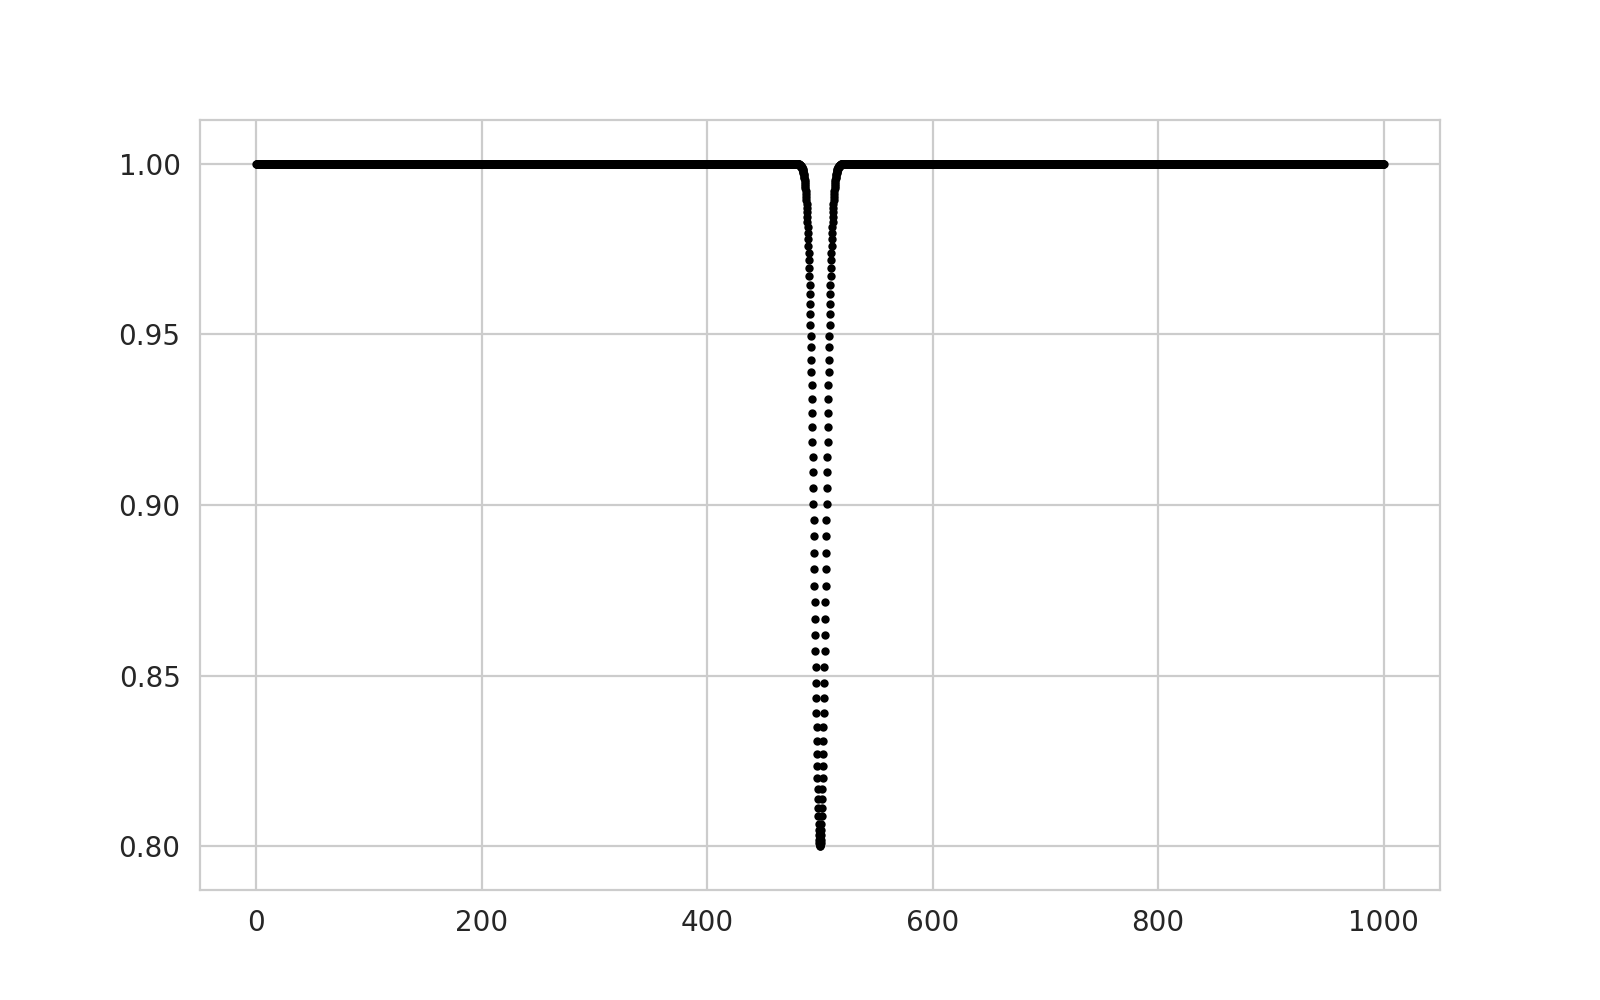

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.scatter(time, flux, color="black", s=4)


Okay, cool, now we want to generate light curves:

In [6]:
def simulate_lightcurves(time, flux, nbands=1, cadence=None, npoints=None, 
                         err=0.02, mean_mag=12.0):
    
    if cadence is None and npoints is None:
        raise ValueError("Either cadence or npoints need to have a value.")
        
    if cadence is not None:
        if cadence.shape[0] != nbands:
            raise ValueError("Need to have a set of cadences for all bands defined in `nbands`")
    
    if npoints is not None:
        if np.size(npoints) != nbands:
            raise ValueError("Need to have a set of `npoints` for all bands defined in `nbands`")

    if np.size(err) != 1 and len(err) != nbands:
        raise ValueError("The errors need to be either a single number or a list" + \
                         "of numbers corresponding to the number of bands.")

        
    if np.size(mean_mag) == 1:
        mean_mag = np.array([mean_mag])
        
    if np.size(err) == 1:
        err = np.array([err])
        
    if np.size(npoints) == 1:
        npoints = np.array([npoints])

    if cadence is not None:
        npoints = np.array([len(c) for c in cadences])
        
    lc_all = []
    # loop over different bands:
    for i in range(nbands):
        # if the cadence is not defined, randomly sample from times 
        if cadence is None:
            #print("i: " + str(i))
            #print("time.shape[0]: " + str((time.shape[0])))
            #print("npoints[i]: " + str(npoints[i]))
                  
            idx = np.sort(np.random.choice(np.arange(time.shape[0]), replace=False, size=npoints[i]))
        else:
            cad = cadence[i]
            idx = time.searchsorted(cad)

        new_time = time[idx]
        new_flux = flux[idx]
        

    
        mag = -2.5*np.log10(new_flux) + np.random.normal(mean_mag[i], err[i], size=npoints[i])

        magerr = np.ones_like(mag) * err[i]
            
        lc = lk.LightCurve(time=new_time, 
                                   flux=mag, 
                                   flux_err=magerr)
        lc_all.append(lc)
        
    return lc_all

Now we can generate an actual light curve from a single band:

In [7]:
np.random.seed(200)
lc_all = simulate_lightcurves(time, flux, nbands=1, npoints=[200], err=0.02, mean_mag=12.0 )

<IPython.core.display.Javascript object>


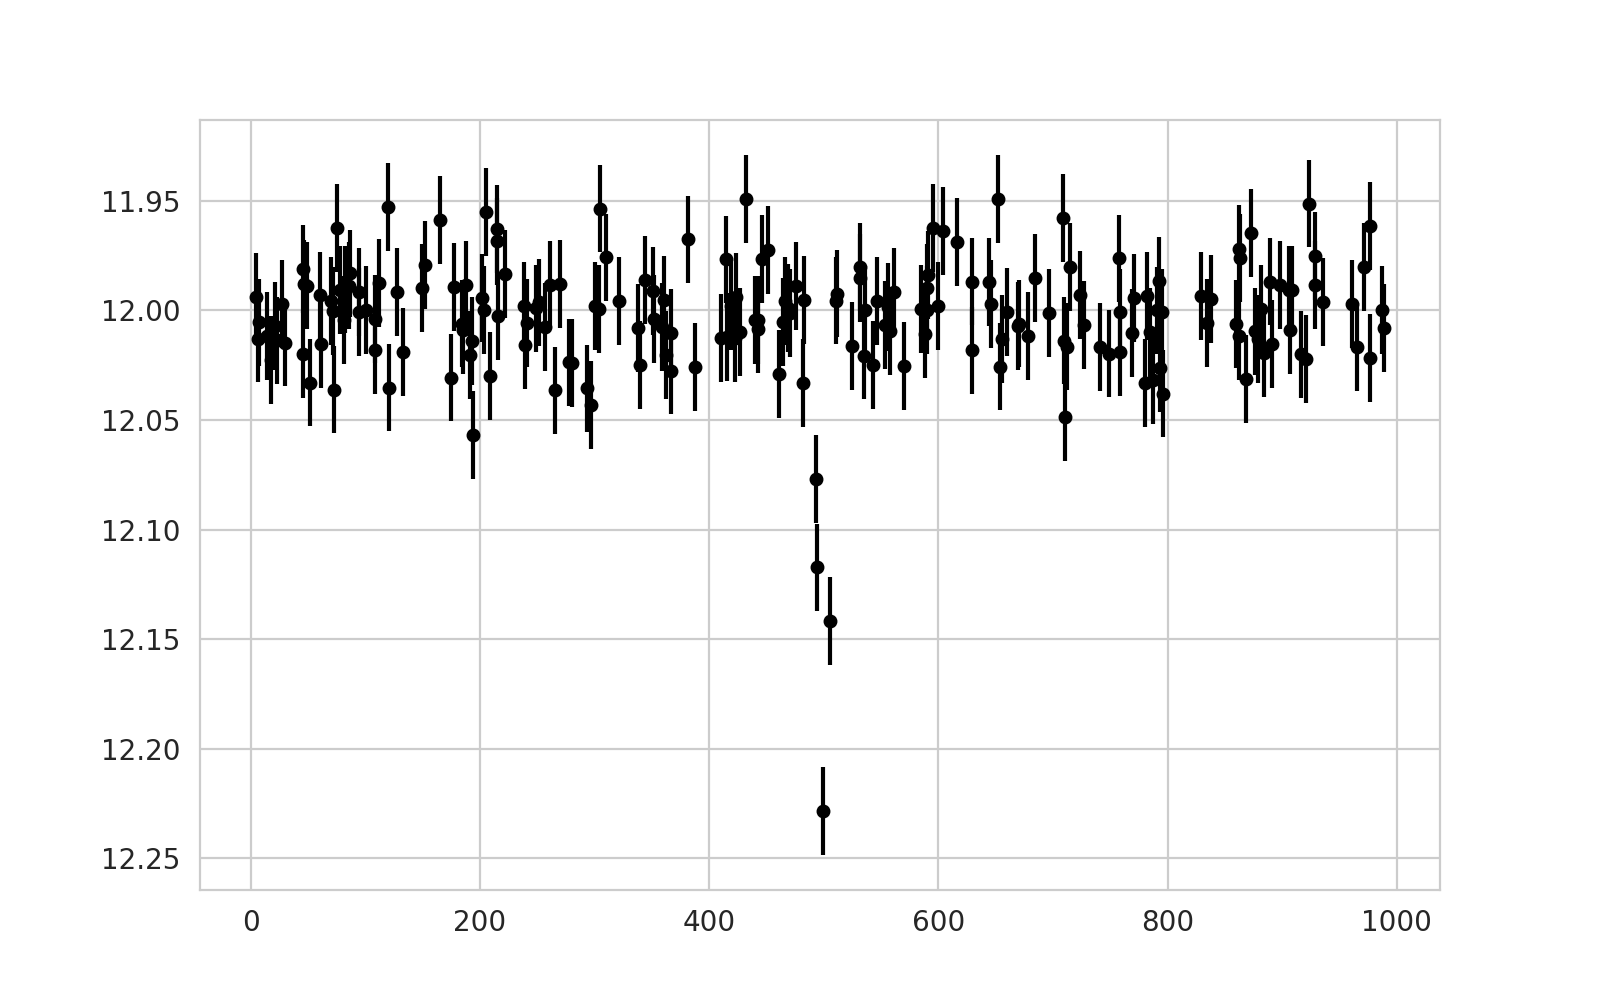

(12.264378759008617, 11.913092967903602)

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.errorbar(lc_all[0].time, lc_all[0].flux, yerr=lc_all[0].flux_err, fmt="o", color="black", markersize=4)
ax.set_ylim(ax.get_ylim()[::-1])

Ok, cool, let's simulate a bunch of these:

<IPython.core.display.Javascript object>


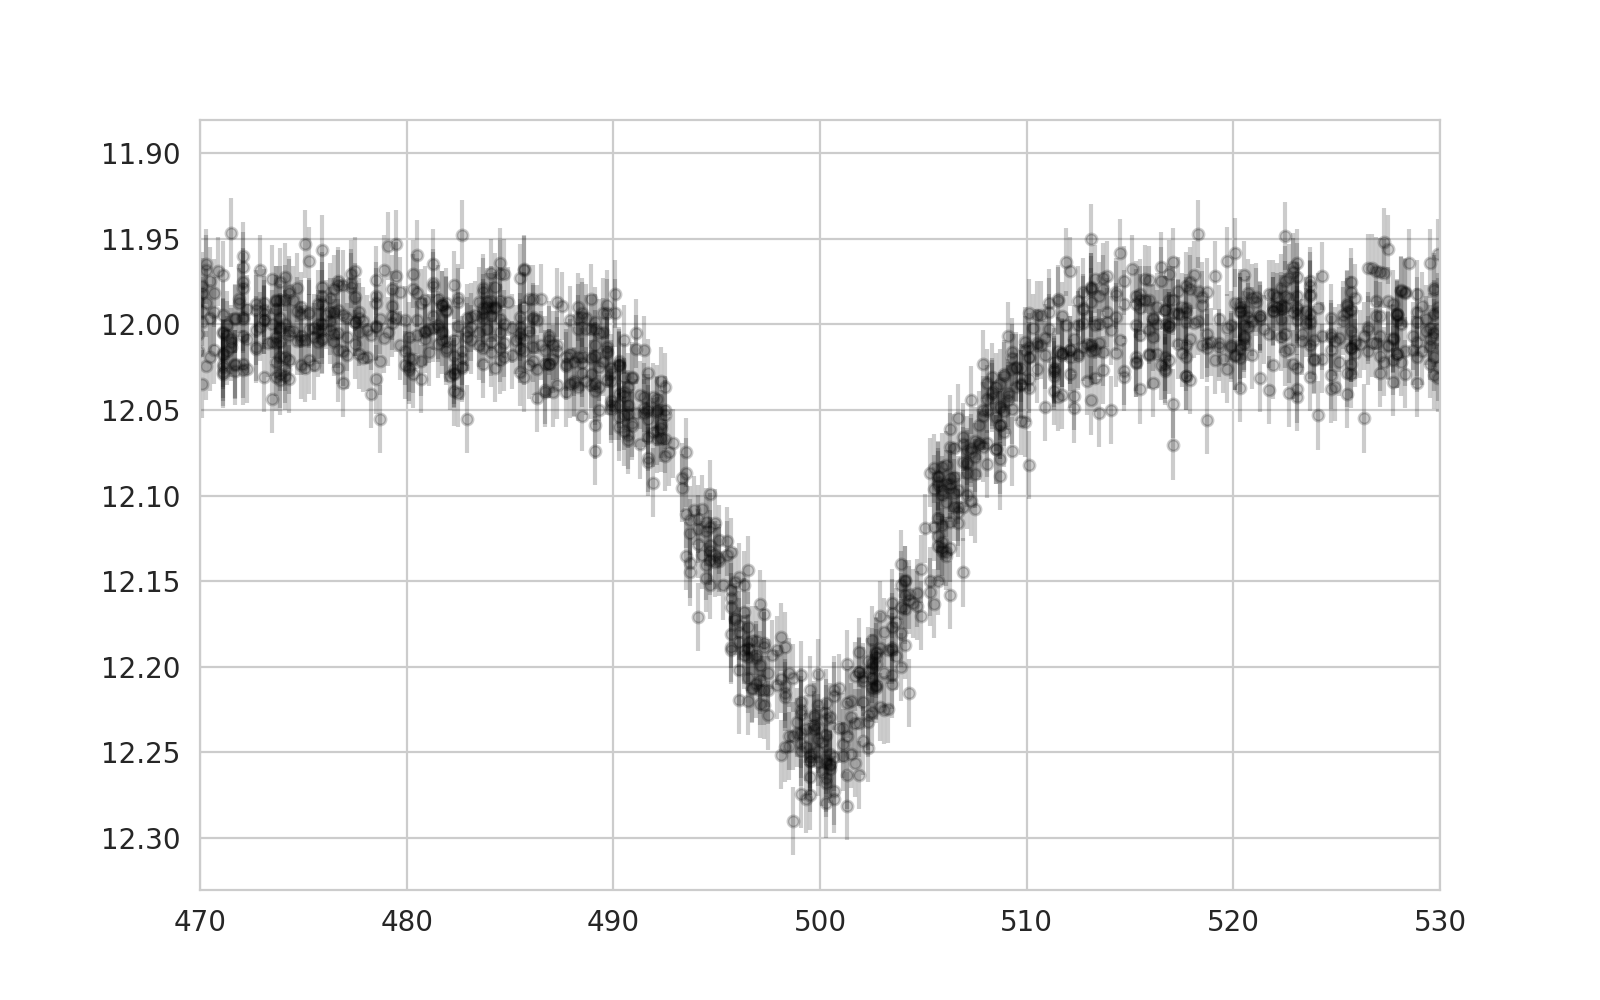

(12.330330631660248, 11.880614417823034)

In [11]:
nsims = 100


fig, ax = plt.subplots(1, 1, figsize=(8,5))

for i in range(nsims):
    
    lc_all = simulate_lightcurves(time, flux, nbands=1, npoints=[200], err=0.02, mean_mag=12.0)
    ax.errorbar(lc_all[0].time, lc_all[0].flux, yerr=lc_all[0].flux_err, fmt="o", 
                color="black", markersize=4, alpha=0.2)

ax.set_xlim(470, 530)
ax.set_ylim(ax.get_ylim()[::-1])

### Simulating multiple dips

Let's try simulating three dips, to figure out how that works:

In [9]:
tseg = 1000
coverage = 10
width = np.array([5.0, 10.0, 7.0])
depth = np.array([0.2, 0.5, 0.1])

In [10]:
time, flux = simulate_dip_flux(tseg, coverage, width, depth)

<IPython.core.display.Javascript object>


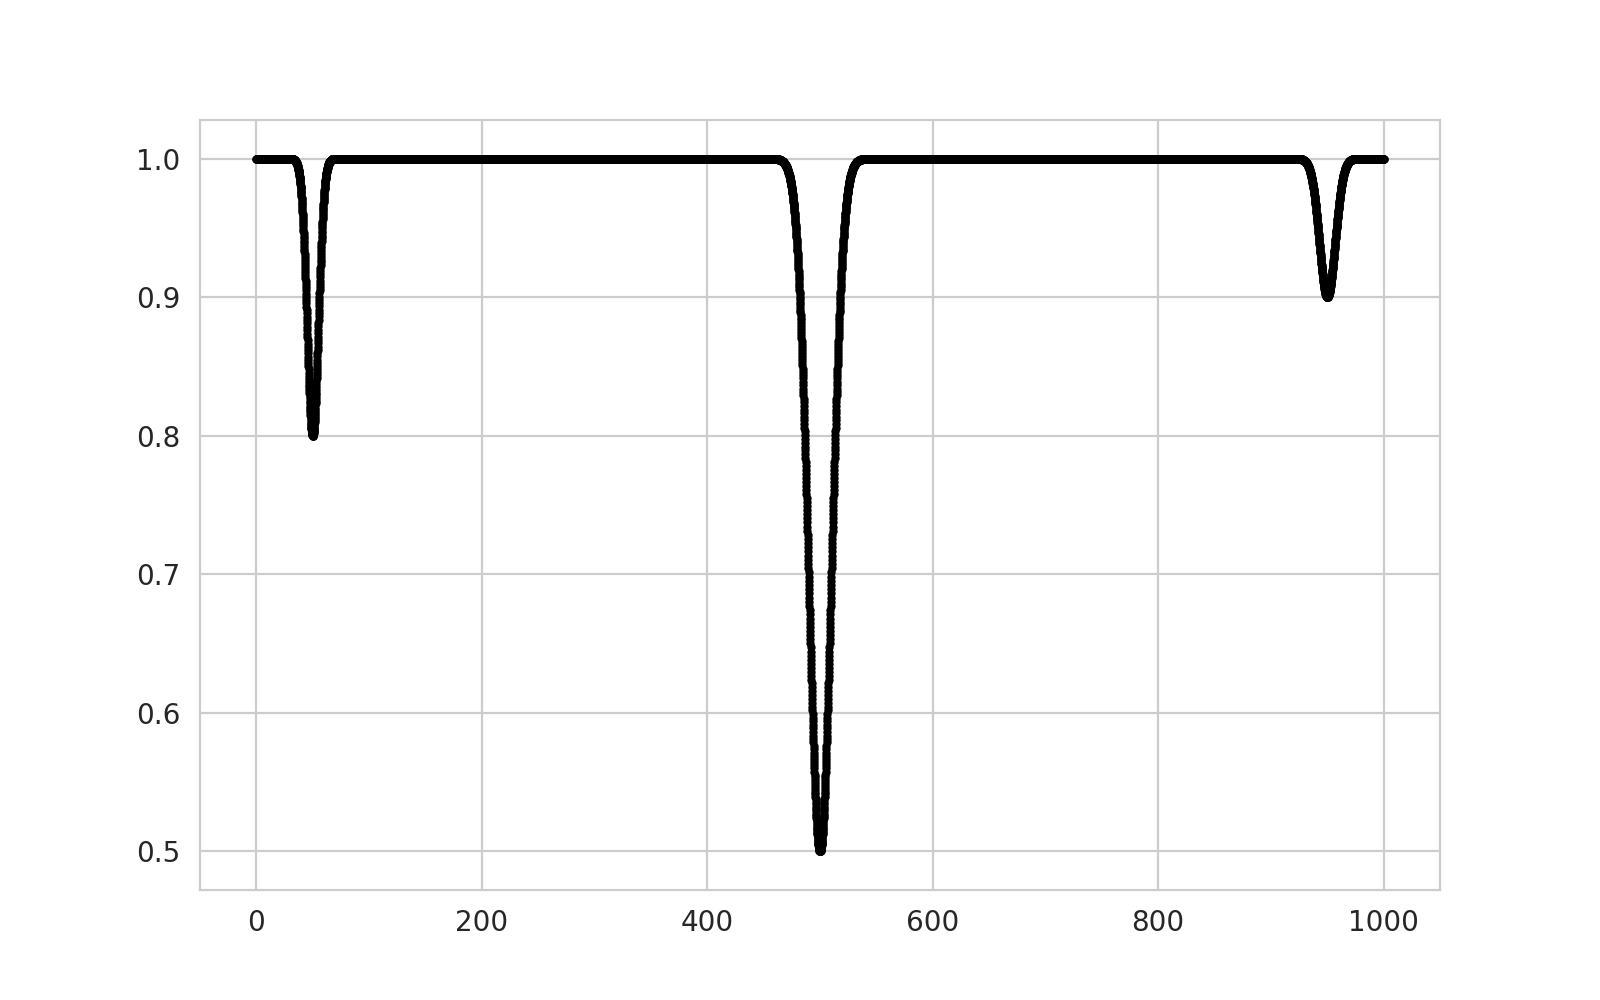

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.scatter(time, flux, color="black", s=4)

Ok, cool: let's make this into an actual light curve:

<IPython.core.display.Javascript object>


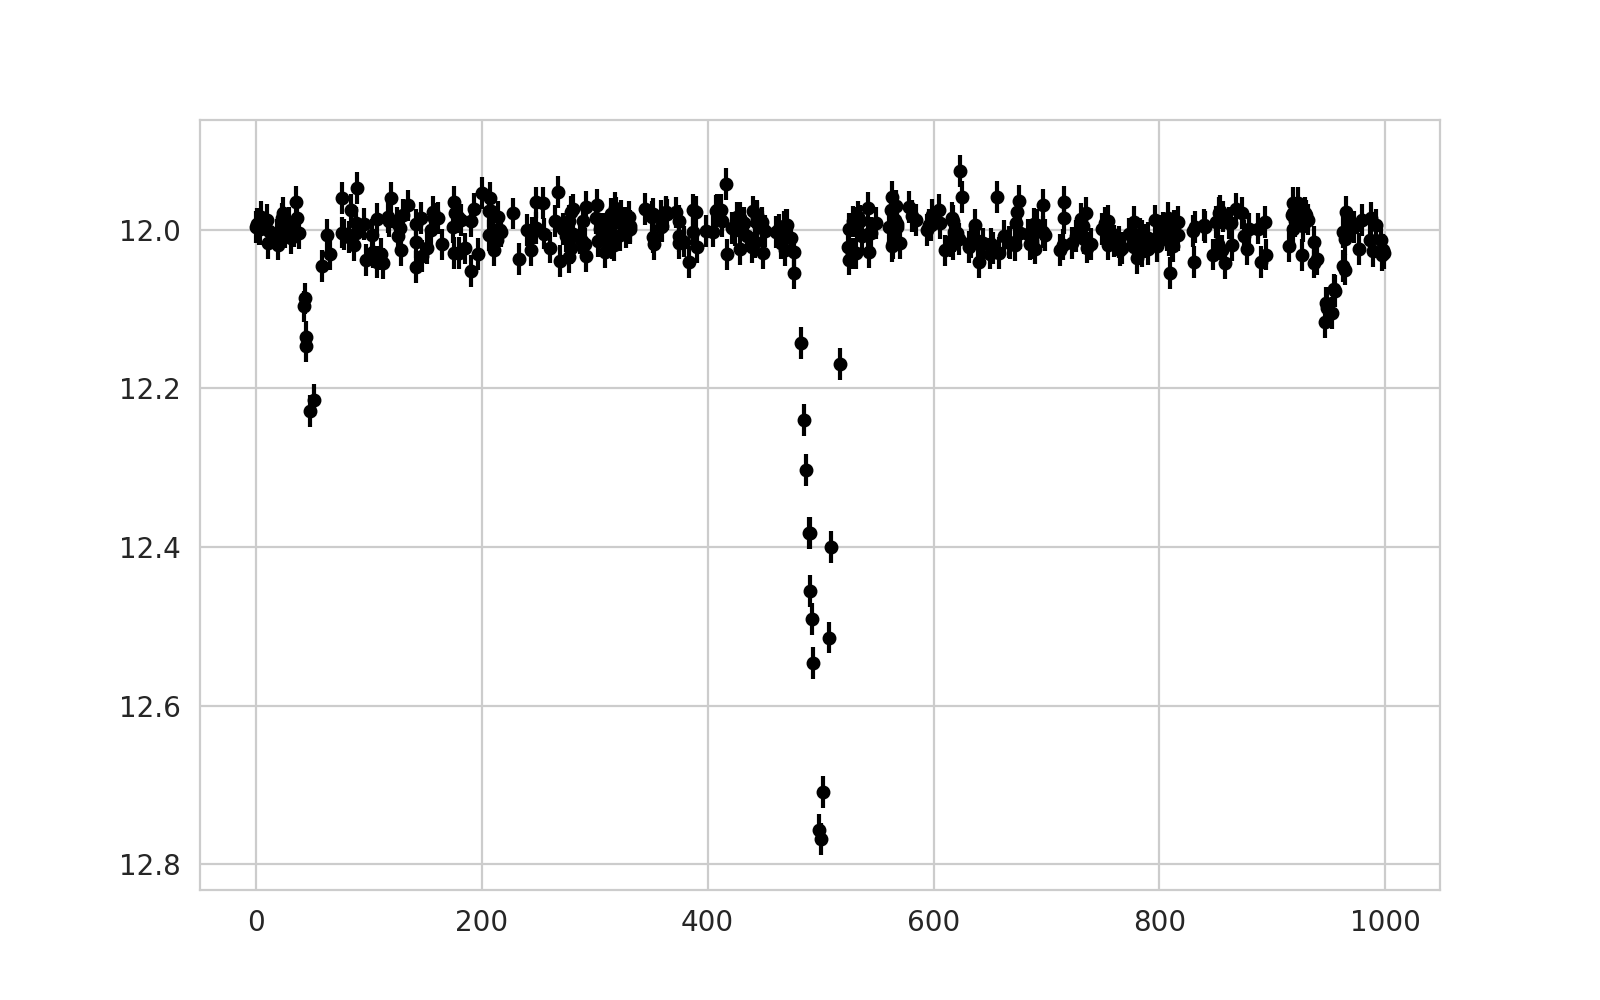

(12.832205178792275, 11.861821539467966)

In [12]:
np.random.seed(200)
lc_all = simulate_lightcurves(time, flux, nbands=1, npoints=[400], err=0.02, mean_mag=12.0 )

fig, ax = plt.subplots(1, 1, figsize=(8,5))

ax.errorbar(lc_all[0].time, lc_all[0].flux, yerr=lc_all[0].flux_err, fmt="o", color="black", markersize=4)
ax.set_ylim(ax.get_ylim()[::-1])

Excellent, that works. Now we really want to generate multiple bands:

<IPython.core.display.Javascript object>


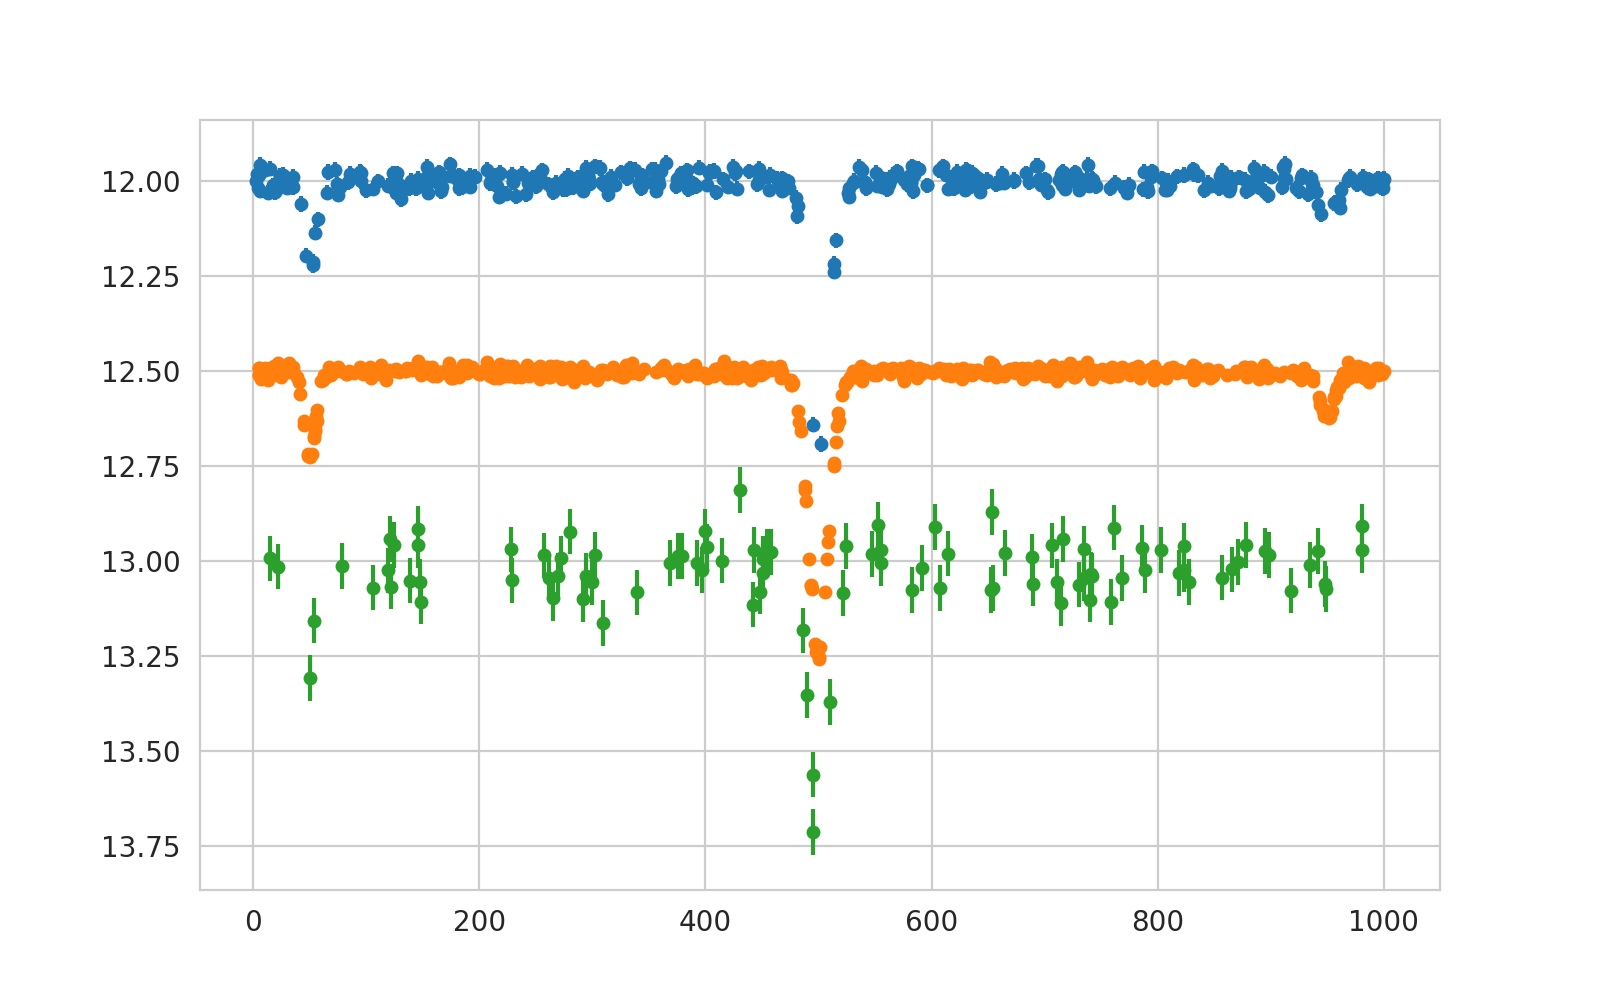

(13.866501752756962, 11.838903631889906)

In [13]:
np.random.seed(400)
lc_all = simulate_lightcurves(time, flux, nbands=3, npoints=[400, 600, 100], 
                              err=[0.02, 0.01, 0.06], mean_mag=[12.0, 12.5, 13.0])

fig, ax = plt.subplots(1, 1, figsize=(8,5))

for lc in lc_all:
    ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)

ax.set_ylim(ax.get_ylim()[::-1])

Okay, so that seems to work, too. 

Let's decide some actual cadences:

<IPython.core.display.Javascript object>


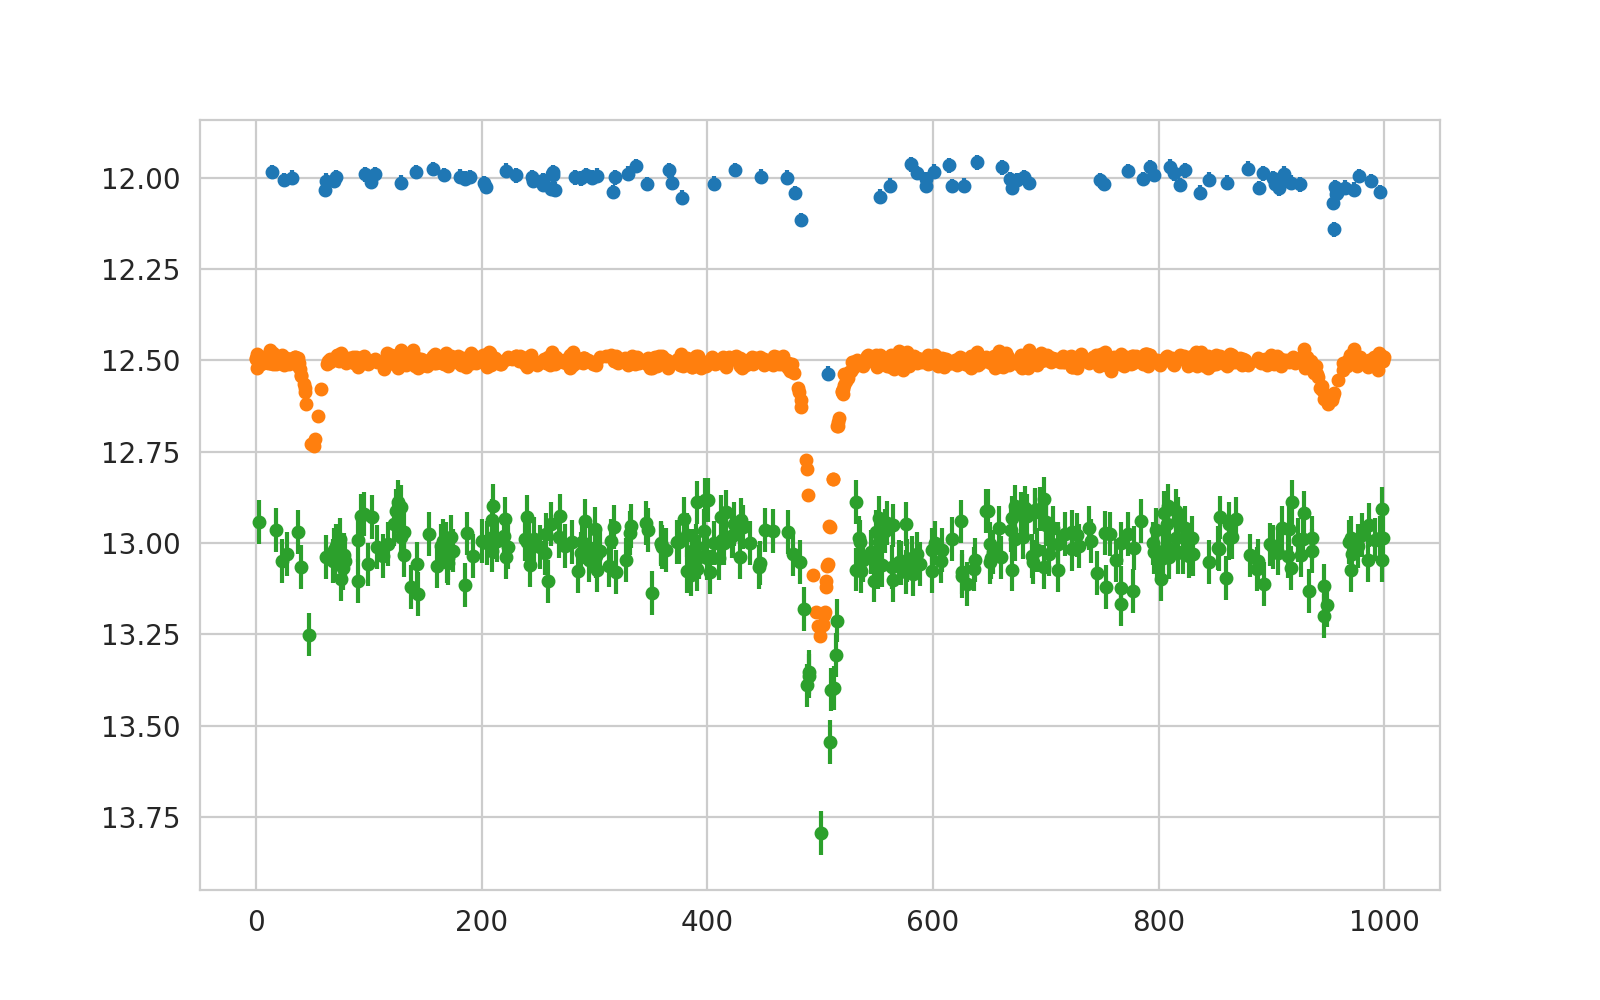

(13.950103241489458, 11.841592075977276)

In [14]:
c1 = np.sort(np.random.uniform(0, tseg, 100))
c2 = np.sort(np.random.uniform(0, tseg, 800))
c3 = np.sort(np.random.uniform(0, tseg, 300))

cadences = np.array([c1, c2, c3])

np.random.seed(1000)
lc_all = simulate_lightcurves(time, flux, nbands=3, cadence=cadences, 
                              err=[0.02, 0.01, 0.06], mean_mag=[12.0, 12.5, 13.0])

fig, ax = plt.subplots(1, 1, figsize=(8,5))

for lc in lc_all:
    ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)

ax.set_ylim(ax.get_ylim()[::-1])

Hooray, that works, too. 

### Importing ZTF Cadences

Now we can import ZTF cadences and errors and hopefully start making realistic light curves:

In [15]:
datadir = "/epyc/data/boyajian/"

pickle_file = "sample_mjds_2.pkl"

In [16]:
ztf_cadence = pd.read_pickle(datadir + pickle_file)

In [17]:
ztf_cadence.head()

,mjd_g,mag_g,magerr_g,mjd_r,mag_r,magerr_r
0,"[58204.201331, 58206.1338889, 58450.4353819, 5...","[18.049786, 17.98969, 17.893917, 17.893661, 17...","[0.043785494, 0.042514425, 0.04061343, 0.04060...","[58475.45729171111, 58450.3772454, 58475.45774...","[17.445889, 17.433268, 17.45091, 17.46019, 17....","[0.029131362, 0.029901987, 0.029236319, 0.0294..."
1,"[58208.4476505, 58208.4842824, 58234.3558912, ...","[16.587982, 16.418648, 16.603691, 16.678661, 1...","[0.027895203, 0.027219111, 0.02796397, 0.02830...","[58502.56362271111, 58502.56866901111, 58502.5...","[15.69869, 15.667656, 15.66051, 15.677812, 15....","[0.012726132, 0.012664719, 0.012650874, 0.0148..."
2,"[58598.42826391111, 58598.42871531111, 58246.3...","[20.503447, 20.104498, 20.468098, 20.198317, 2...","[0.1468122, 0.12067488, 0.120341174, 0.1270227...","[58694.26076391111, 58723.21578701111, 58217.4...","[19.5084, 19.513474, 19.416594, 19.455902, 19....","[0.08006927, 0.08037927, 0.08319566, 0.0769301..."
3,"[58205.4712847, 58246.3551505, 58728.162881911...","[19.52711, 19.600018, 19.734375, 19.756207, 19...","[0.07429419, 0.07745236, 0.097713016, 0.084637...","[58694.26076391111, 58723.21578701111, 58666.3...","[18.070387, 18.075138, 18.075306, 18.28212, 18...","[0.029745415, 0.029832937, 0.029836038, 0.0340..."
4,"[58599.37923613333, 58235.417419, 58274.377963...","[20.6547, 19.874813, 20.611324, 20.21209, 20.3...","[0.14792758, 0.09857254, 0.13027763, 0.1135262...","[58700.21489581111, 58686.27434031111, 58700.2...","[19.047123, 19.245966, 19.162663, 19.18438, 19...","[0.06769094, 0.07629721, 0.07256523, 0.0735206..."


I have a function that returns data from that table in a dictionary:

In [18]:
def get_ztf_lightcurve(ztf_df, idx):
    """
    Get a dictionary with ZTF points in r and g bands out 
    of the cadence data frame
    
    Parameters
    ----------
    ztf_df : pd.DataFrame
        A DataFrame with the ZTF data, has columns `mjd_g`, `mag_g`, 
        `magerr_g`, `mjd_r`, `mag_r`, `magerr_r`
        
    idx: int
        An index in ztf_df.index to choose a particular light curve
        
    Returns
    -------
    ztf_lc : dict
        A dictionary with the data in a given row of the DataFrame
    """
    
    ztf_line = ztf_df.loc[idx]
    mjd_g = ztf_line[0]
    mag_g = ztf_line[1]
    magerr_g = ztf_line[2]
    g_idx = np.argsort(mjd_g)
    mjd_g = mjd_g[g_idx]
    mag_g = mag_g[g_idx]
    magerr_g = magerr_g[g_idx]
    
    mjd_r = ztf_line[3]
    mag_r = ztf_line[4]
    magerr_r = ztf_line[5]

    r_idx = np.argsort(mjd_r)
    mjd_r = mjd_r[r_idx]
    mag_r = mag_r[r_idx]
    magerr_r = magerr_r[r_idx]
    
    tseg_g = mjd_g.max() - mjd_g.min()
    tseg_r = mjd_r.max() - mjd_r.min()

    ztf_lc = {"mjd_g": mjd_g, "mag_g": mag_g, "magerr_g": magerr_g,
              "mjd_r": mjd_r, "mag_r": mag_r, "magerr_r": magerr_r,
              "meanmag_g": np.mean(mag_g), "meanmag_r": np.mean(mag_r),
              "tseg_g": tseg_g, "tseg_r": tseg_r,
              "ng": len(mjd_g), "nr": len(mjd_r), 
              "zero_g": mjd_g[0], "zero_r":mjd_r[0]}
    
    return ztf_lc

In [19]:
ztf_lc = get_ztf_lightcurve(ztf_cadence, 10)

In [20]:
print("Total length in g band: " + str(ztf_lc["tseg_g"]))
print("Total length in r band: " + str(ztf_lc["tseg_r"]))

Total length in g band: 153.6687963000004
Total length in r band: 451.8157986111037


Now I can hopefully stick that cadence into my simulated dips:

<IPython.core.display.Javascript object>


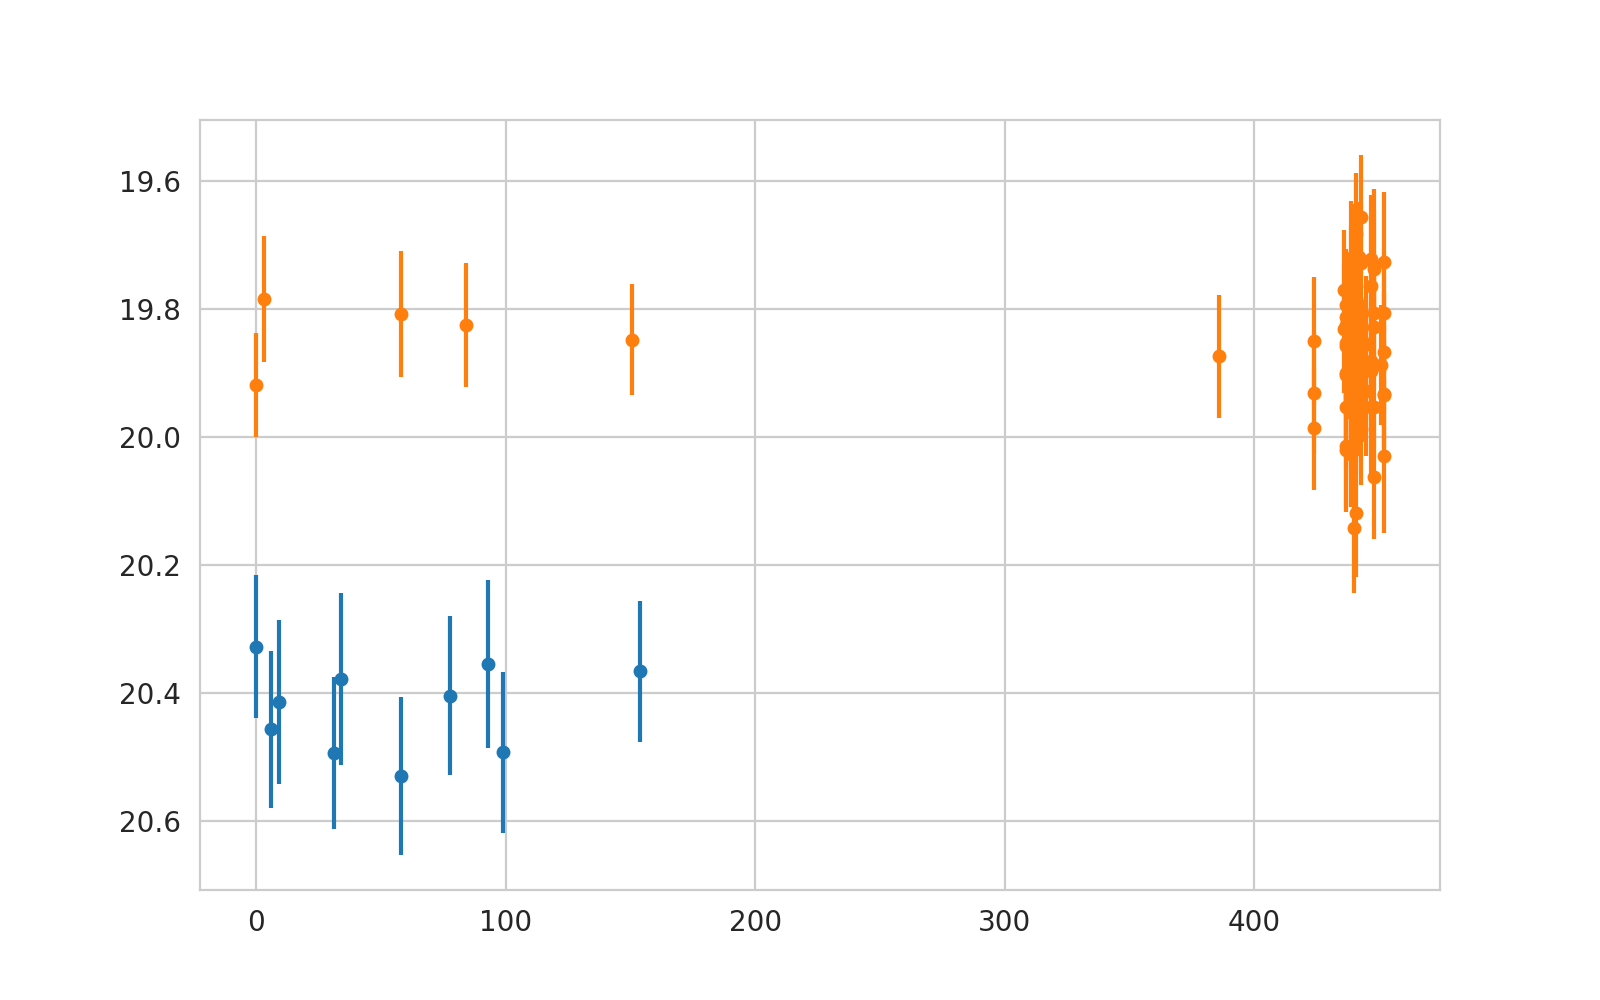

(20.707452755154414, 19.503881066641288)

In [21]:
c1 = ztf_lc["mjd_g"] - ztf_lc["zero_g"]
c2 = ztf_lc["mjd_r"] - ztf_lc["zero_r"]

cadences = np.array([c1, c2])
nbands = 2
mean_mag = np.array([ztf_lc["meanmag_g"], ztf_lc["meanmag_r"]])
err = np.array([ztf_lc["magerr_g"], ztf_lc["magerr_r"]])

np.random.seed(1000)
lc_all = simulate_lightcurves(time, flux, nbands=nbands, cadence=cadences, 
                              err=err, mean_mag=mean_mag)

fig, ax = plt.subplots(1, 1, figsize=(8,5))

for lc in lc_all:
    ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)

ax.set_ylim(ax.get_ylim()[::-1])

Well, that' plots a thing!

## Simulate 1 Dip, Same Depth + Width

Let's start by simulating a single dip with the same depth and width:

In [22]:
width = 5.0
depth = 0.5

coverage = 5
tseg = 1000

time, flux = simulate_dip_flux(tseg, coverage, width, depth)

Before we do this on the ZTF cadences, I want to get a feeling for how high the relevant scores should be from the dip detection function:

In [26]:
npoints = [100, 200, 500, 1000]
nsims = 1000

lc_sims_all = []
res_sims_all = []
for npts in npoints:
    lc_sims = []
    res_sims = []
    for i in range(nsims):
        lc_all = simulate_lightcurves(time, flux, nbands=1, npoints=np.array([npts]), err=0.02, mean_mag=12.0)
        t_all = [lc.time for lc in lc_all]
        mag_all = [lc.flux for lc in lc_all]
        magerr_all = [lc.flux_err for lc in lc_all]

        res = measure_dip(t_all, mag_all, magerr_all)
        lc_sims.append(lc_all[0])
        res_sims.append(res)
    lc_sims_all.append(lc_sims)
    res_sims_all.append(res_sims)

In [28]:
res

{'integral': 8.79723438540078,
 'integral_uncertainty': 0.15757219243712864,
 'significance': 55.829865976580095,
 'start_mjd': 491.29690825635987,
 'center_mjd': 499.8634656754362,
 'end_mjd': 508.531724041479,
 'length': 17.23481578511911,
 'window_start_mjd': 474.50687300857567,
 'window_end_mjd': 525.5055738839927,
 'max_gap': 3.0006001200239893,
 'ref_pull_std': 1.0273386802152296,
 'ref_large_pull_fraction': 0.003121748178980229,
 'observation_count': 19,
 'significant_observation_count': 19,
 'core_not_significant_fraction': 0.0,
 'significant_width': 16.203240648129622}

<IPython.core.display.Javascript object>


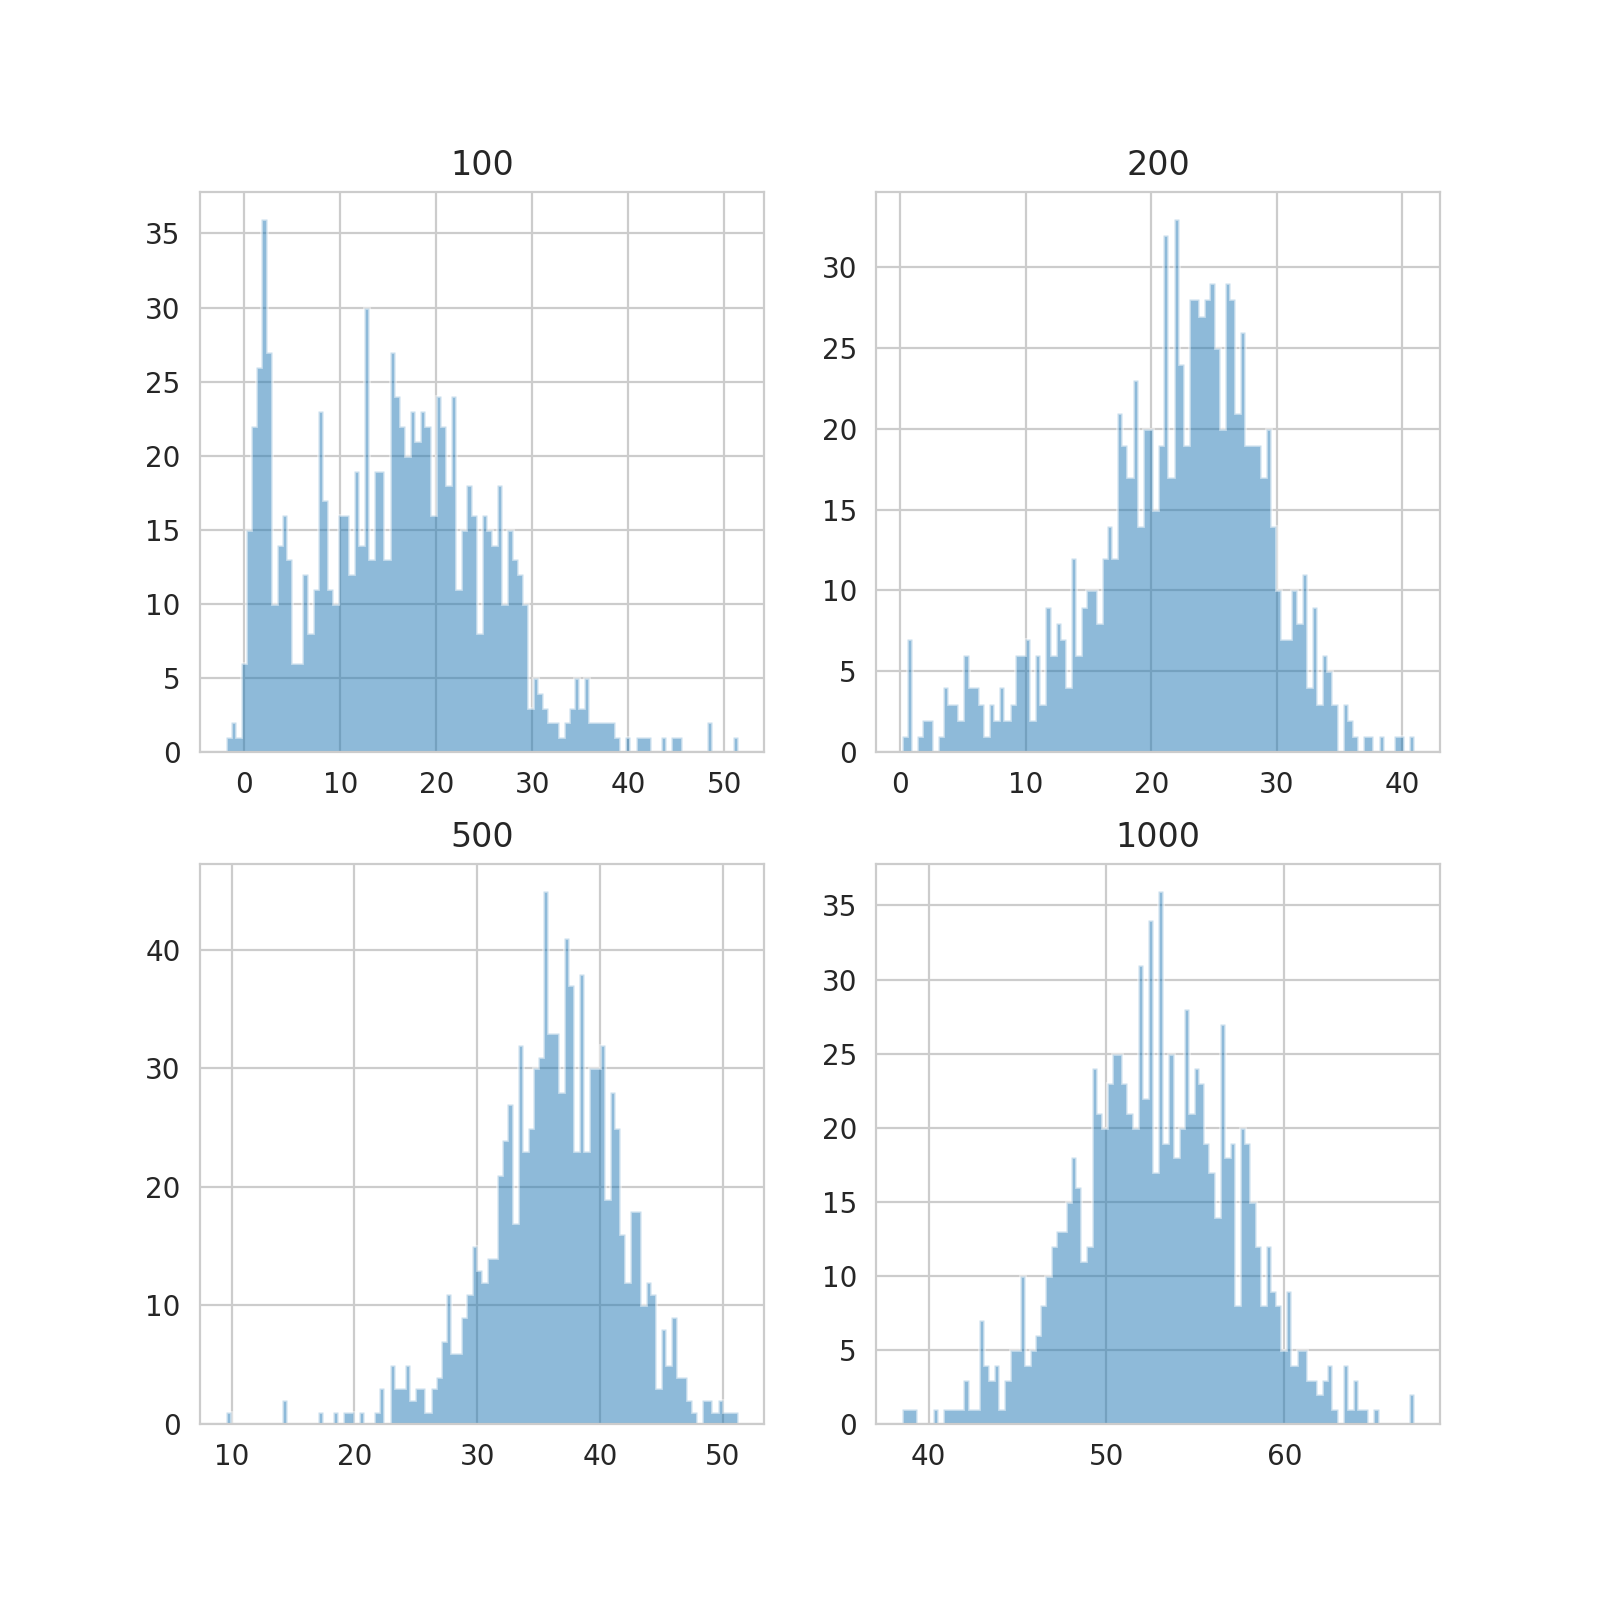

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))

axes = np.hstack(axes)

for i in range(len(res_sims_all)):
    res_sims = res_sims_all[i]
    sig_sims = np.array([res["significance"] for res in res_sims])
    axes[i].hist(sig_sims, bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(npoints[i])

All right, that's useful to know. Let's now take a look at the ZTF cadences:

In [31]:
nztf = len(ztf_cadence)

In [32]:
idx_all = np.random.randint(0, nztf, size=10000)

In [33]:
lc_sim_all = []

tseg = time[-1] - time[0]

for idx in idx_all:
    ztf_lc = get_ztf_lightcurve(ztf_cadence, idx)
    max_time = np.max([ztf_lc["tseg_g"], ztf_lc["tseg_r"]])
    min_time = np.min([ztf_lc["zero_g"], ztf_lc["zero_r"]])
    
    max_start = tseg - max_time
    
    tstart = np.random.uniform(0, max_start, size=1)
    
    c1 = ztf_lc["mjd_g"] - ztf_lc["zero_g"] + tstart
    c2 = ztf_lc["mjd_r"] - ztf_lc["zero_r"] + tstart

    cadences = np.array([c1, c2])
    nbands = 2
    mean_mag = np.array([ztf_lc["meanmag_g"], ztf_lc["meanmag_r"]])
    magerr_g = ztf_lc["magerr_g"]
    magerr_r = ztf_lc["magerr_r"]
    magerr_g[magerr_g <= 0.0] = np.mean(magerr_g)
    magerr_r[magerr_r <= 0.0] = np.mean(magerr_r)
    err = np.array([magerr_g, magerr_r])
    
    lc_all = simulate_lightcurves(time, flux, nbands=nbands, cadence=cadences, 
                                  err=err, mean_mag=mean_mag)

    lc_sim_all.append(lc_all)


Now let's try to look for dips using Kyle's code:

In [166]:
from dipper import measure_dip

<IPython.core.display.Javascript object>


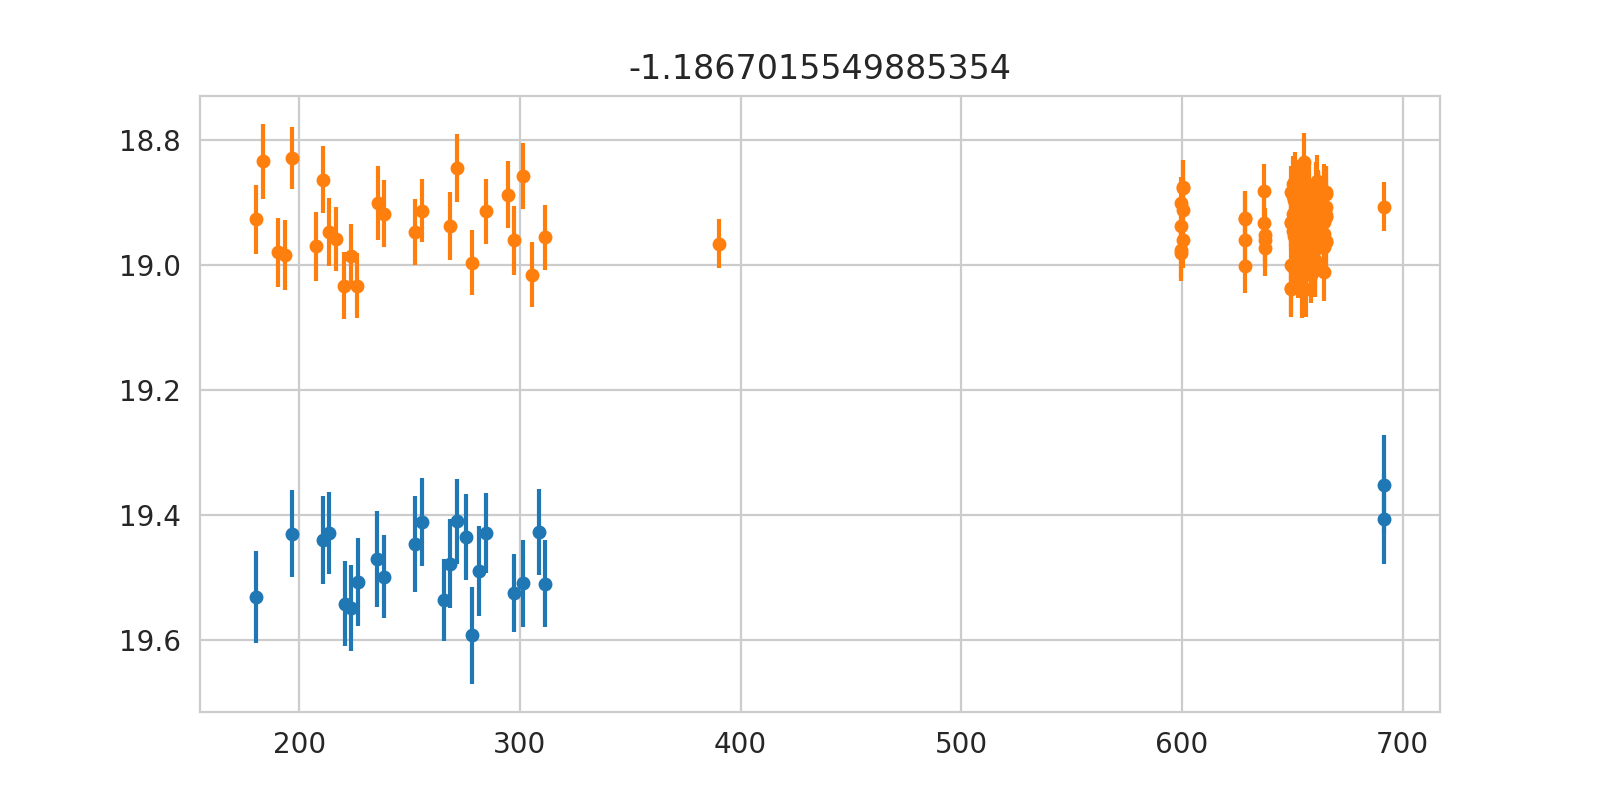

<IPython.core.display.Javascript object>


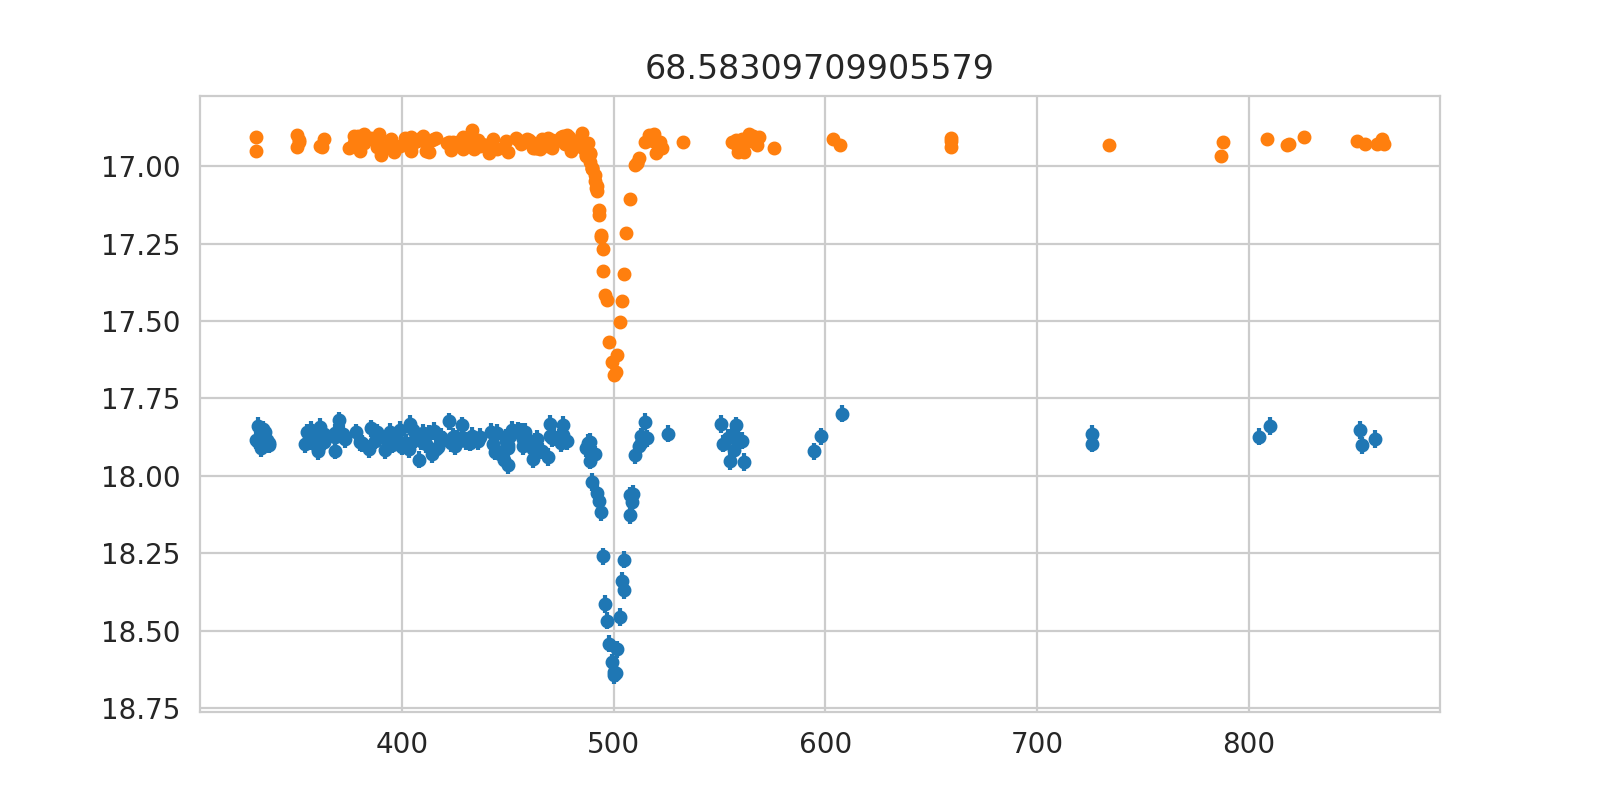

<IPython.core.display.Javascript object>


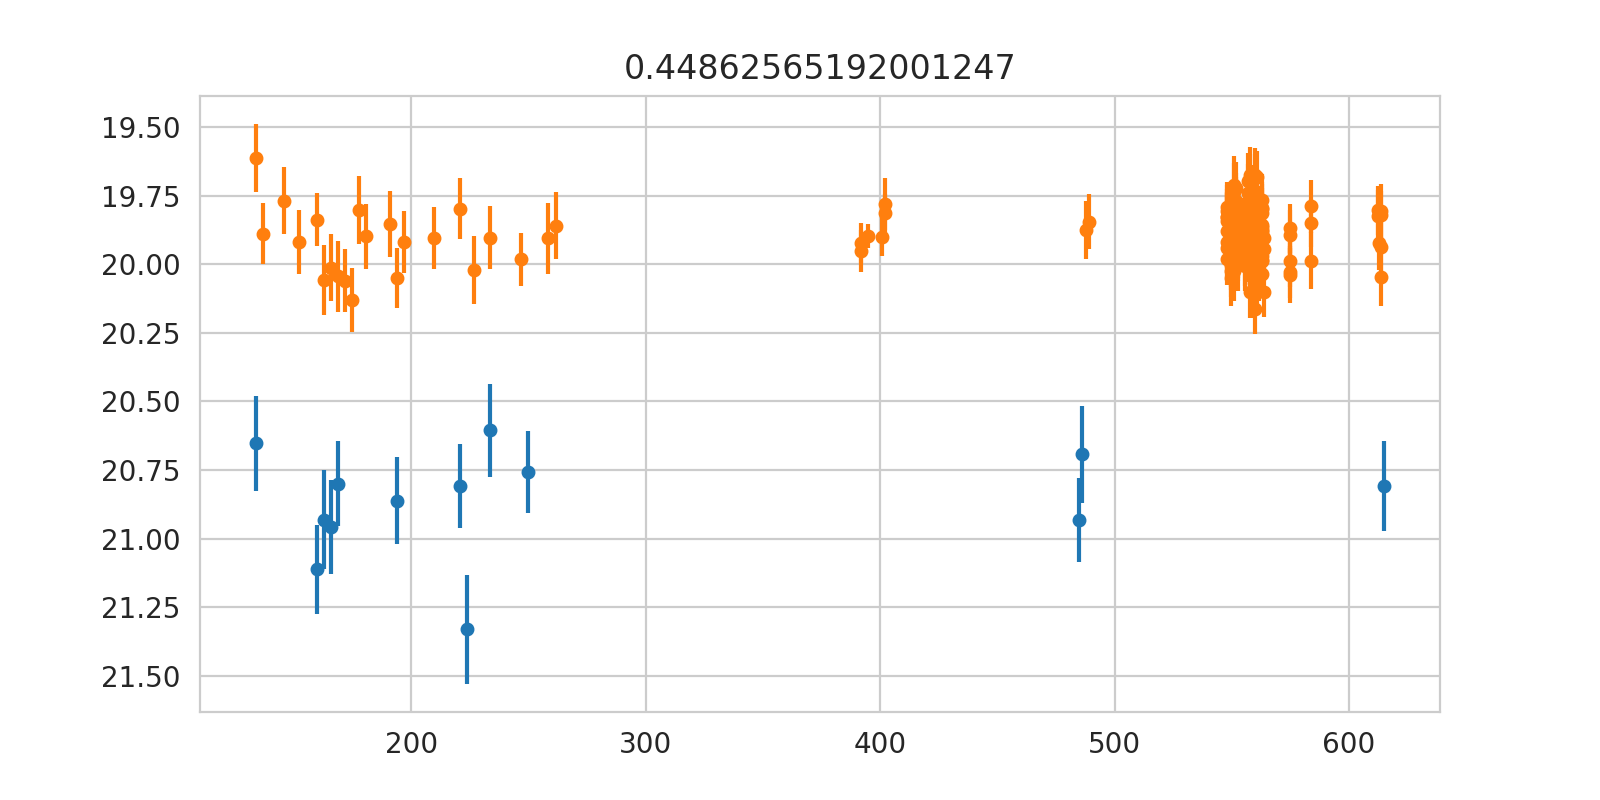

<IPython.core.display.Javascript object>


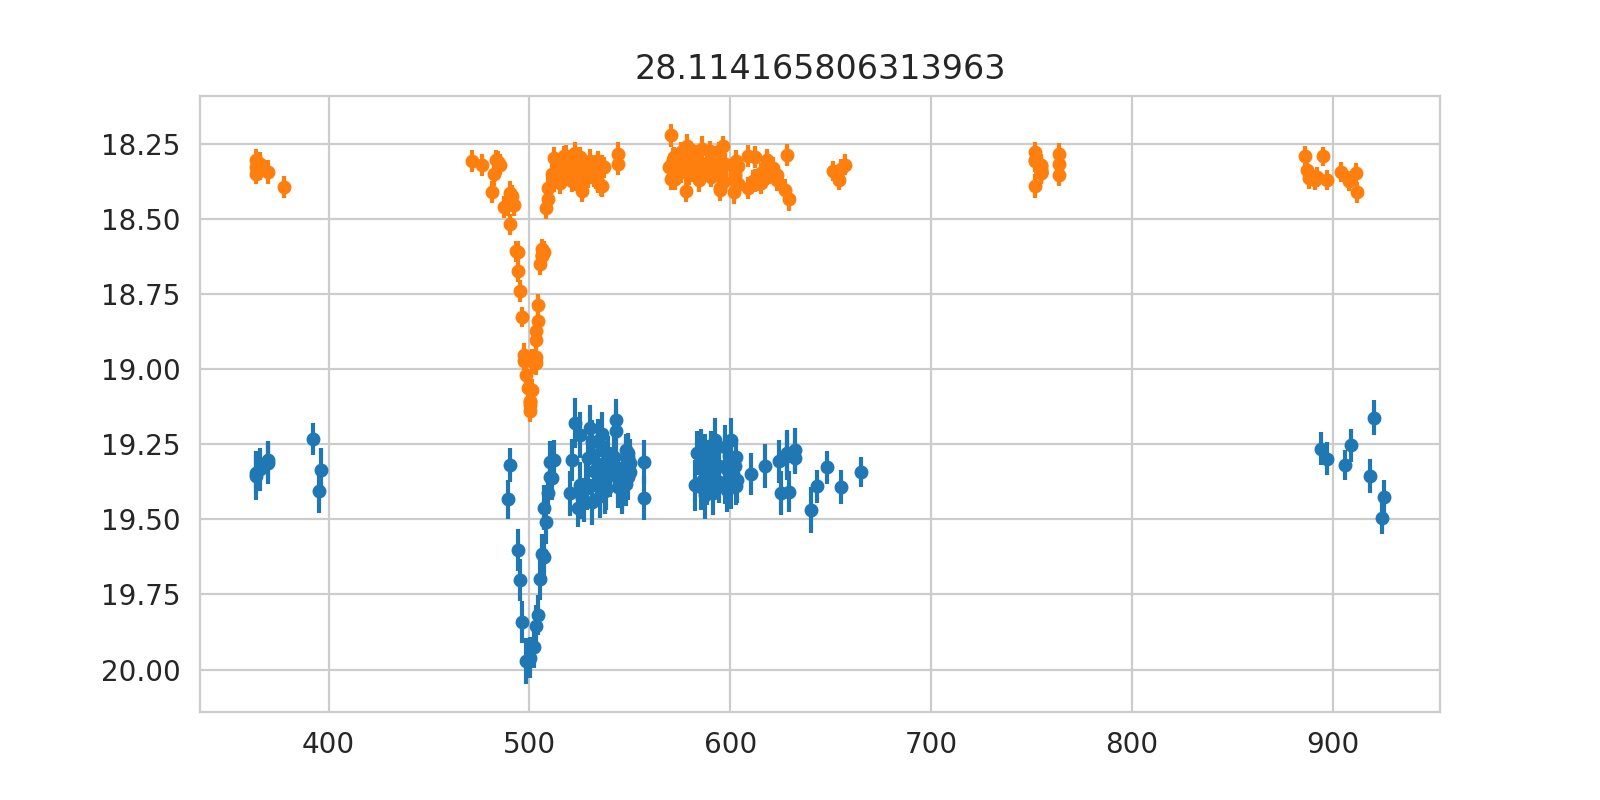

<IPython.core.display.Javascript object>


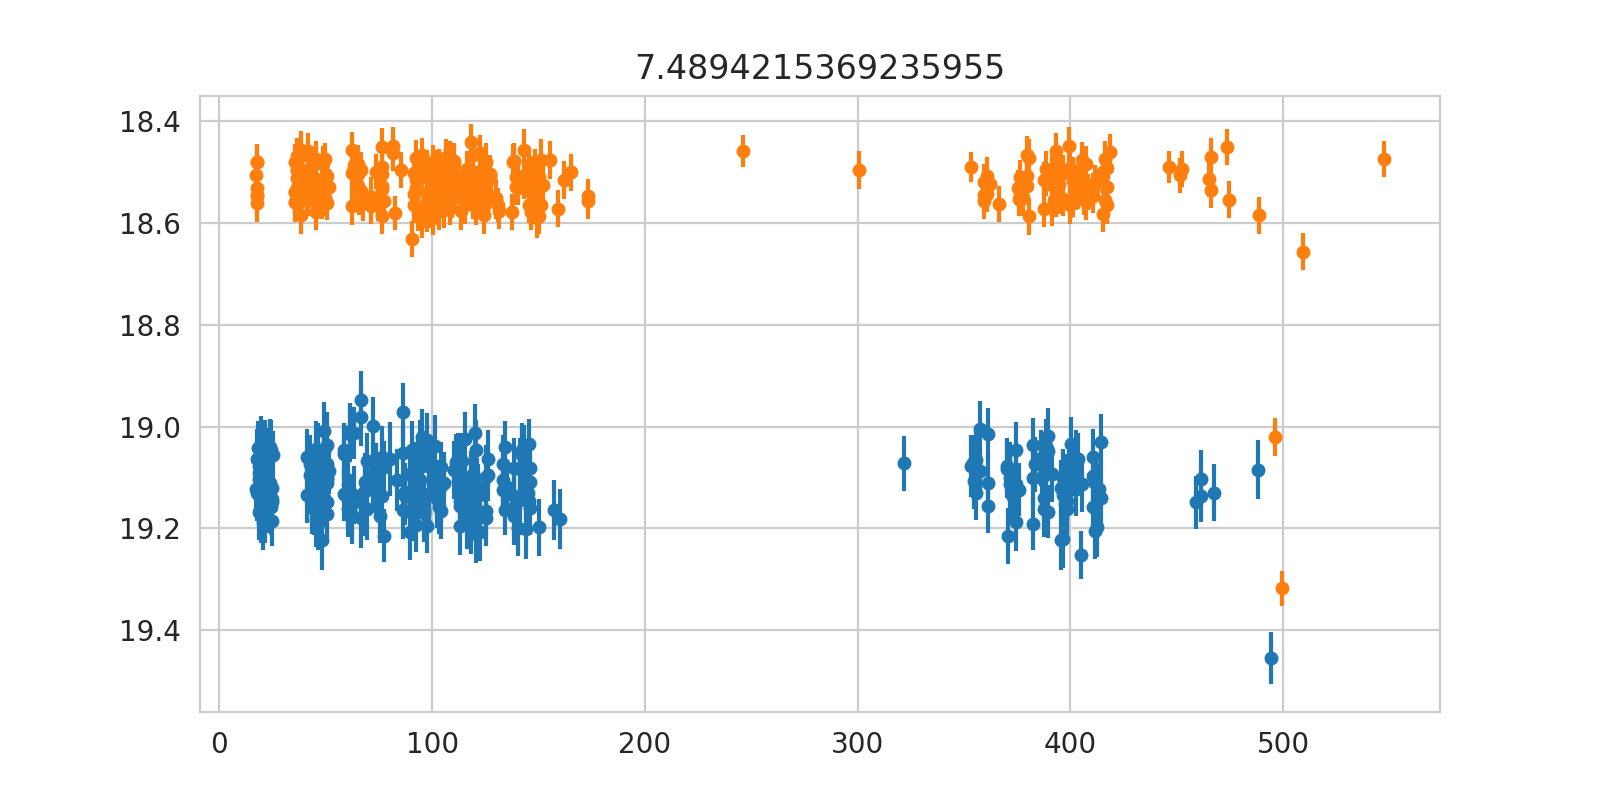

<IPython.core.display.Javascript object>


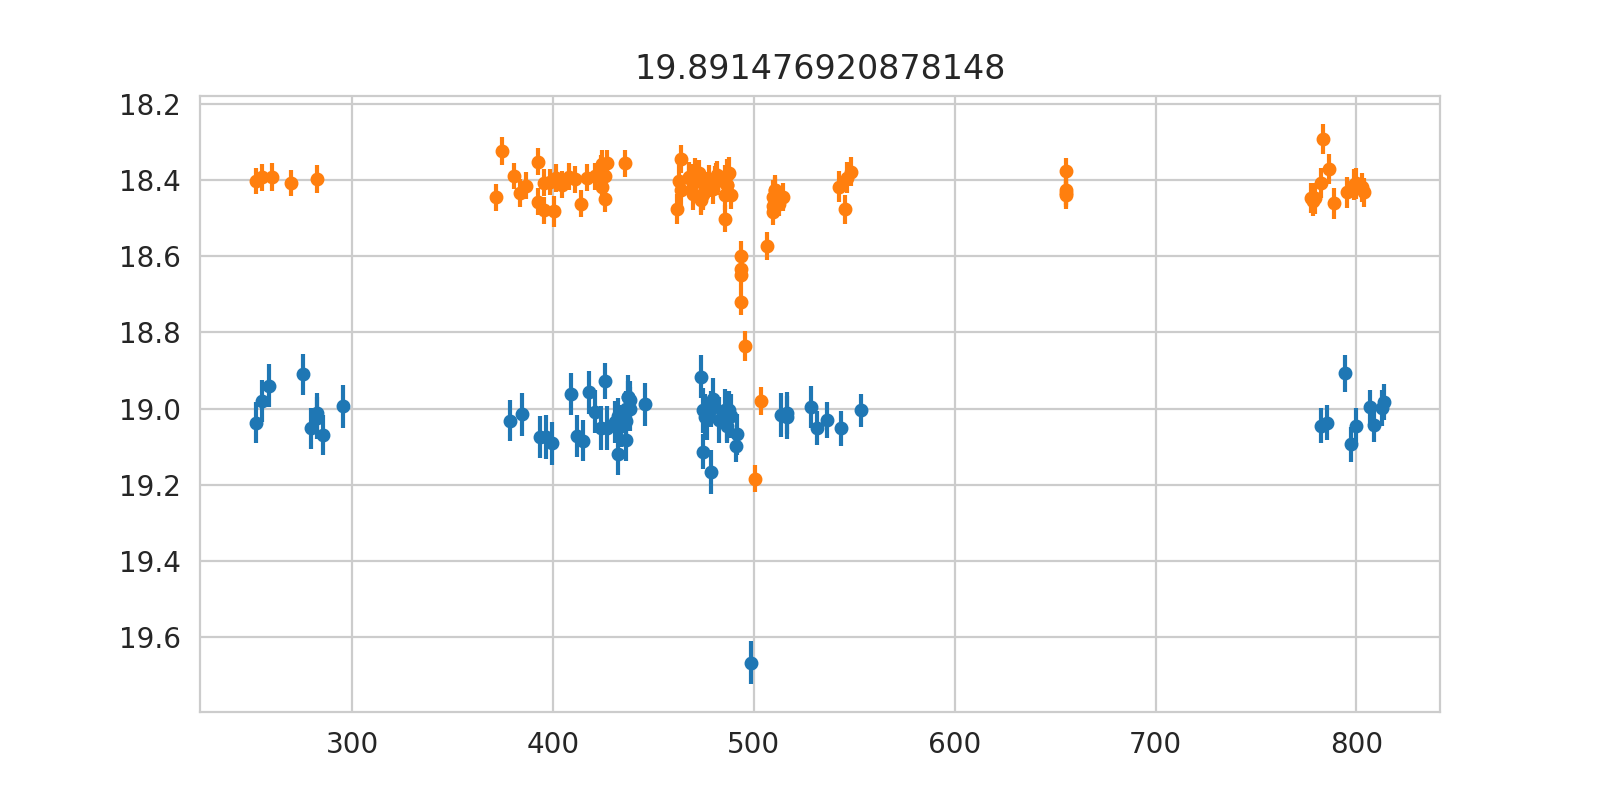

<IPython.core.display.Javascript object>


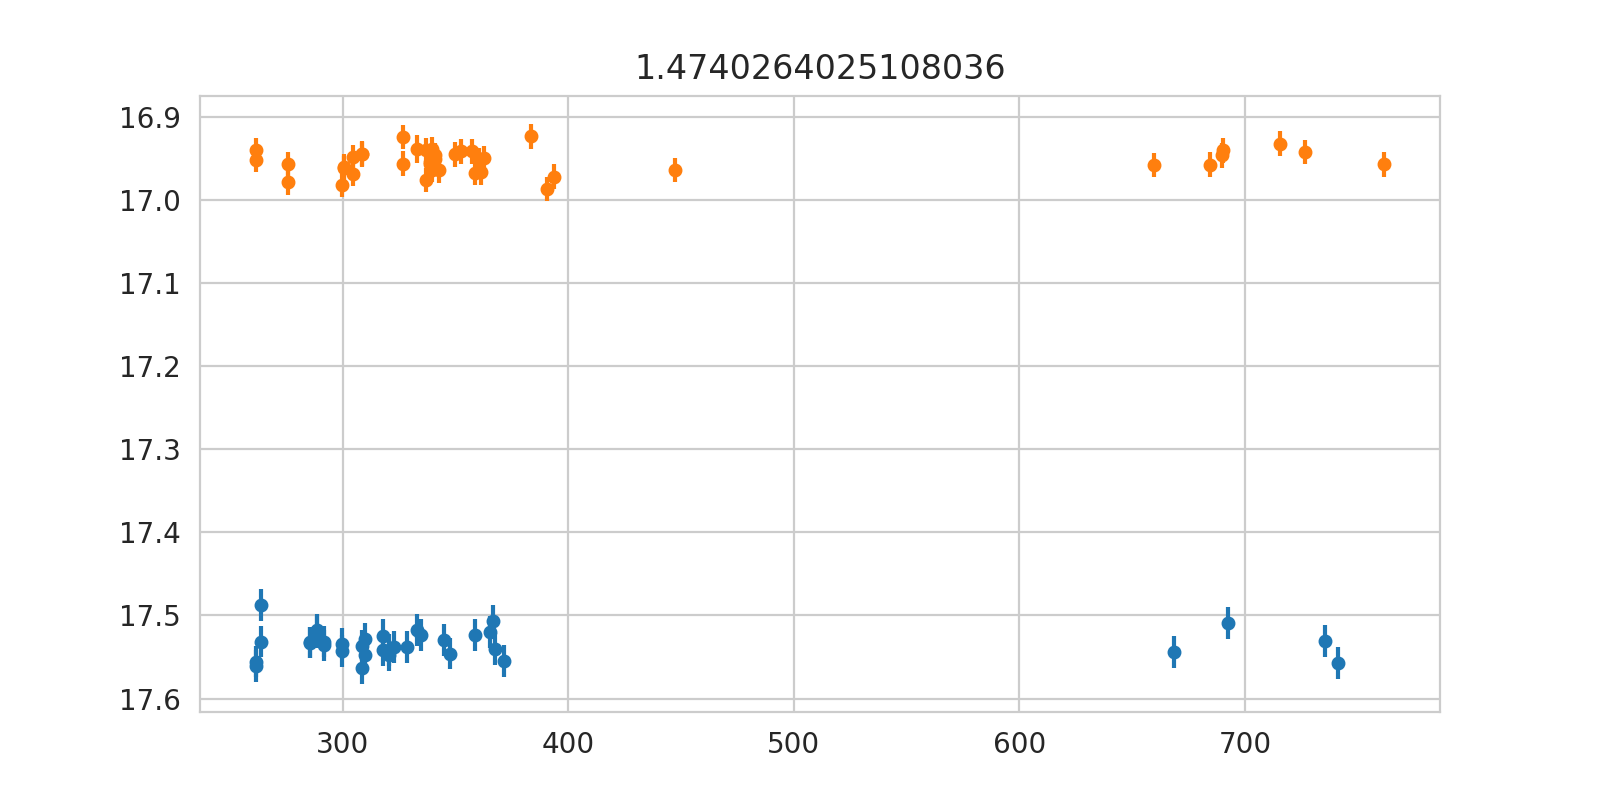

<IPython.core.display.Javascript object>


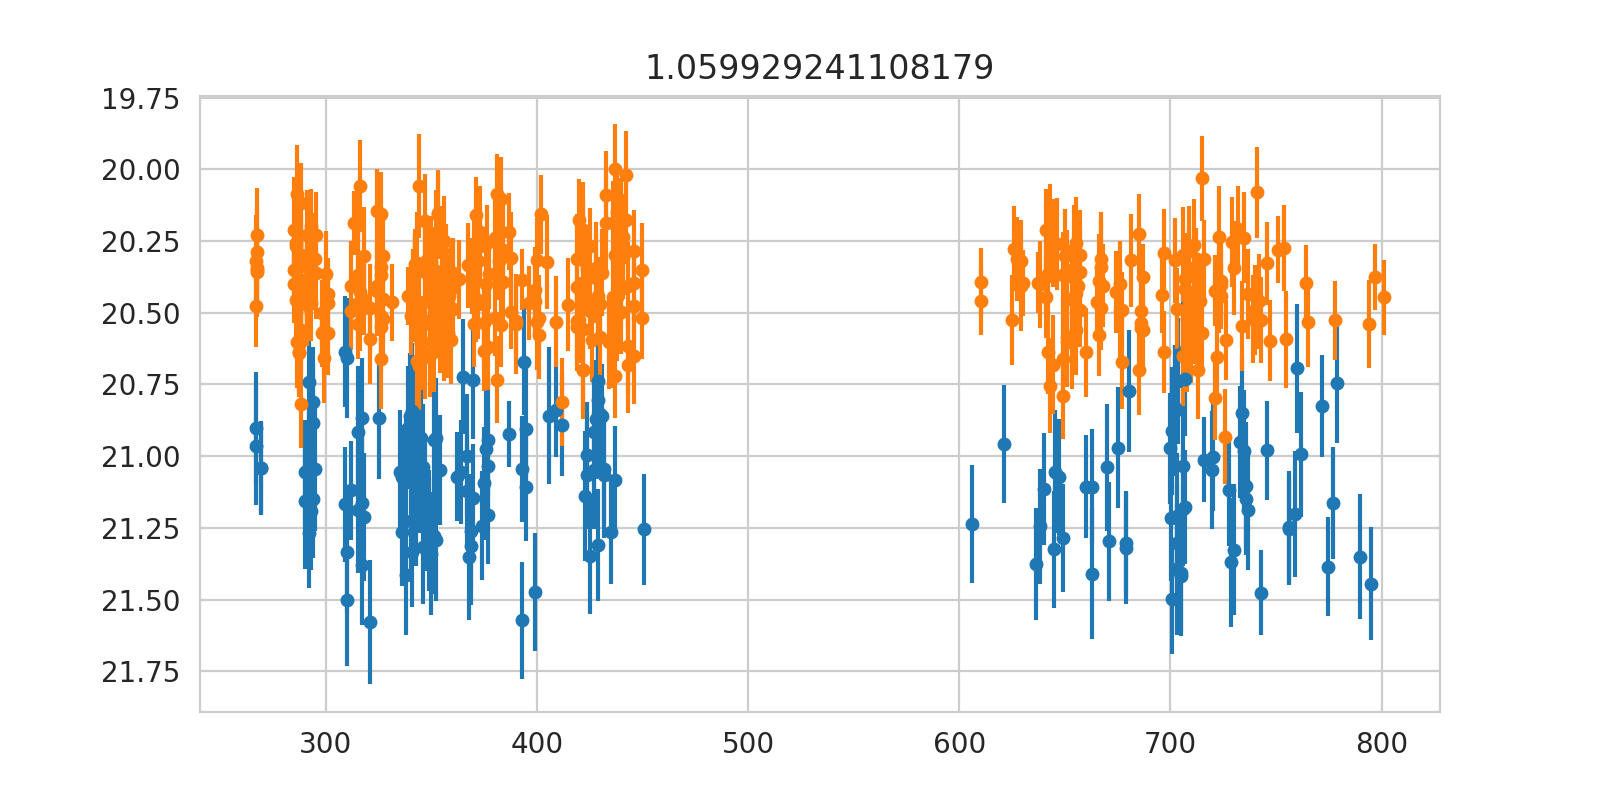

<IPython.core.display.Javascript object>


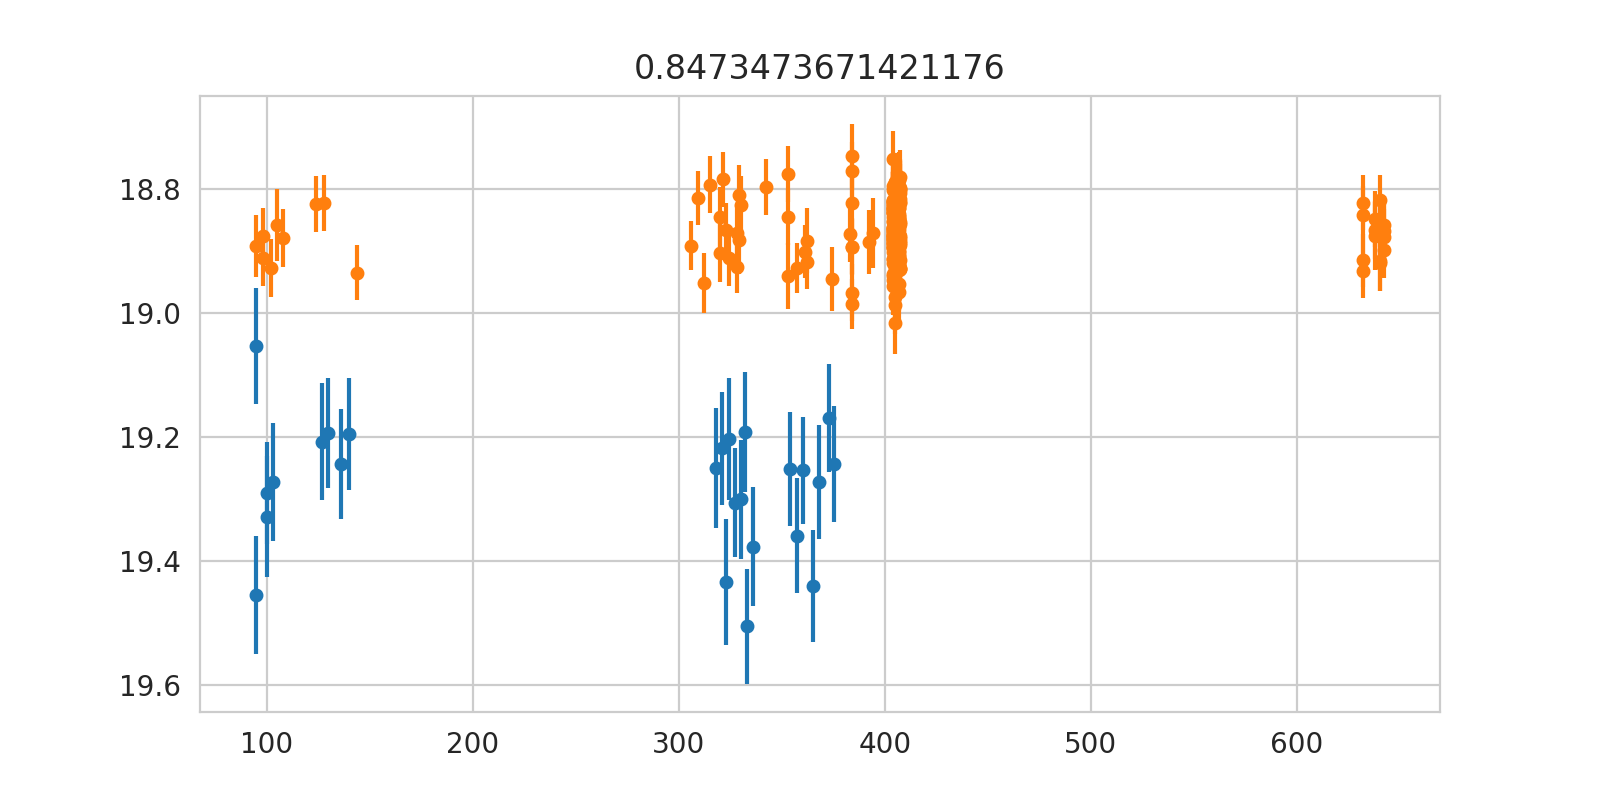

<IPython.core.display.Javascript object>


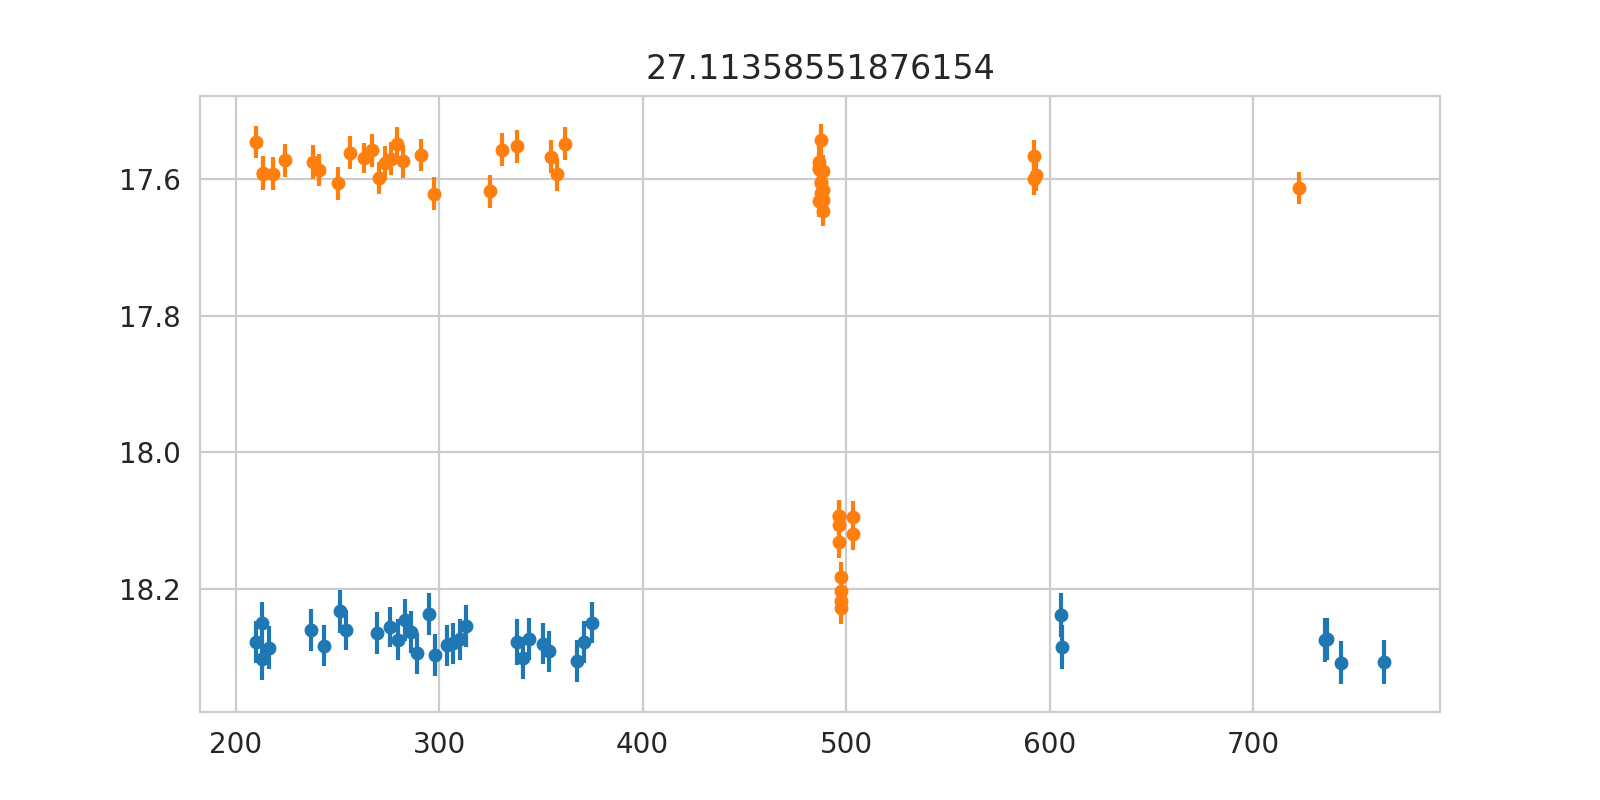

In [44]:
for i in range(10):
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    lc_all = lc_sim_all[i]
    t_all = [lc.time for lc in lc_all]
    mag_all = [lc.flux for lc in lc_all]
    magerr_all = [lc.flux_err for lc in lc_all]

    res = measure_dip(t_all, mag_all, magerr_all)
    
    for lc in lc_all:
        ax.errorbar(lc.time, lc.flux, yerr=lc.flux_err, fmt="o", markersize=4)
    
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_title(res["significance"])


Okay, I'm going to take a look at scores > 20:

Okay, so that works. Now we can do this for all of our simulated light curves:

In [45]:
res_all = []

for lc_all in lc_sim_all:
    t_all = [lc.time for lc in lc_all]
    mag_all = [lc.flux for lc in lc_all]
    magerr_all = [lc.flux_err for lc in lc_all]

    res = measure_dip(t_all, mag_all, magerr_all)
    res_all.append(res)

Let's make a histogram of all the significances:

In [46]:
sig_all = np.array([res["significance"] for res in res_all])

<IPython.core.display.Javascript object>


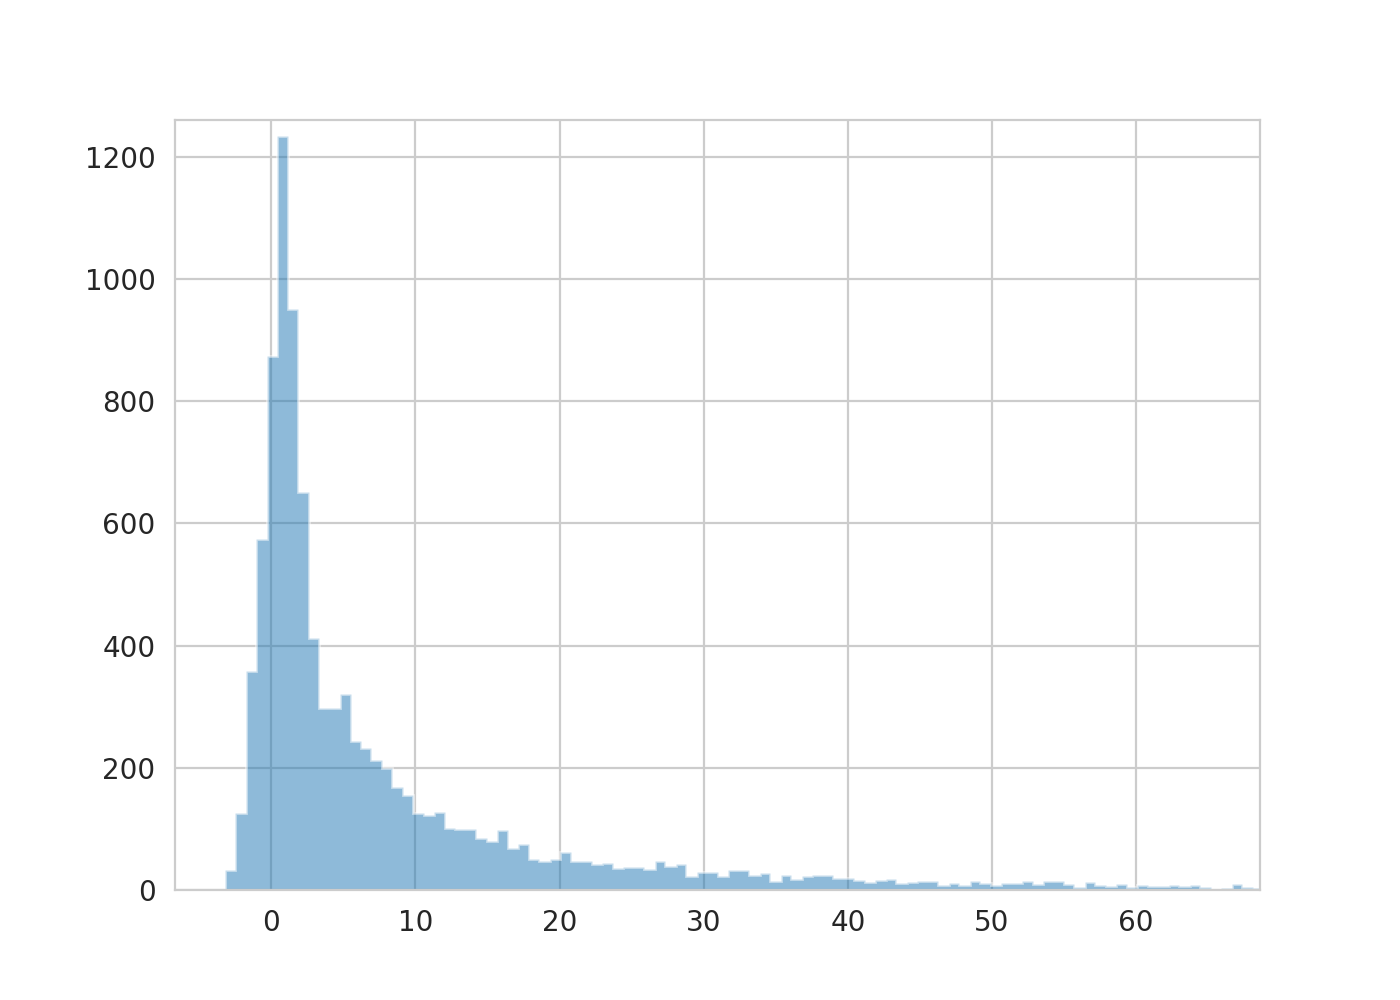

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))

ax.hist(sig_all, bins=200, histtype="stepfilled", alpha=0.5);

We are going to look at the high-signal examples.
Let's look at some different examples with different scores:

In [48]:
np.min(sig_all)

-3.2326416133140743

In [49]:
np.max(sig_all)

142.3362663332497

<IPython.core.display.Javascript object>


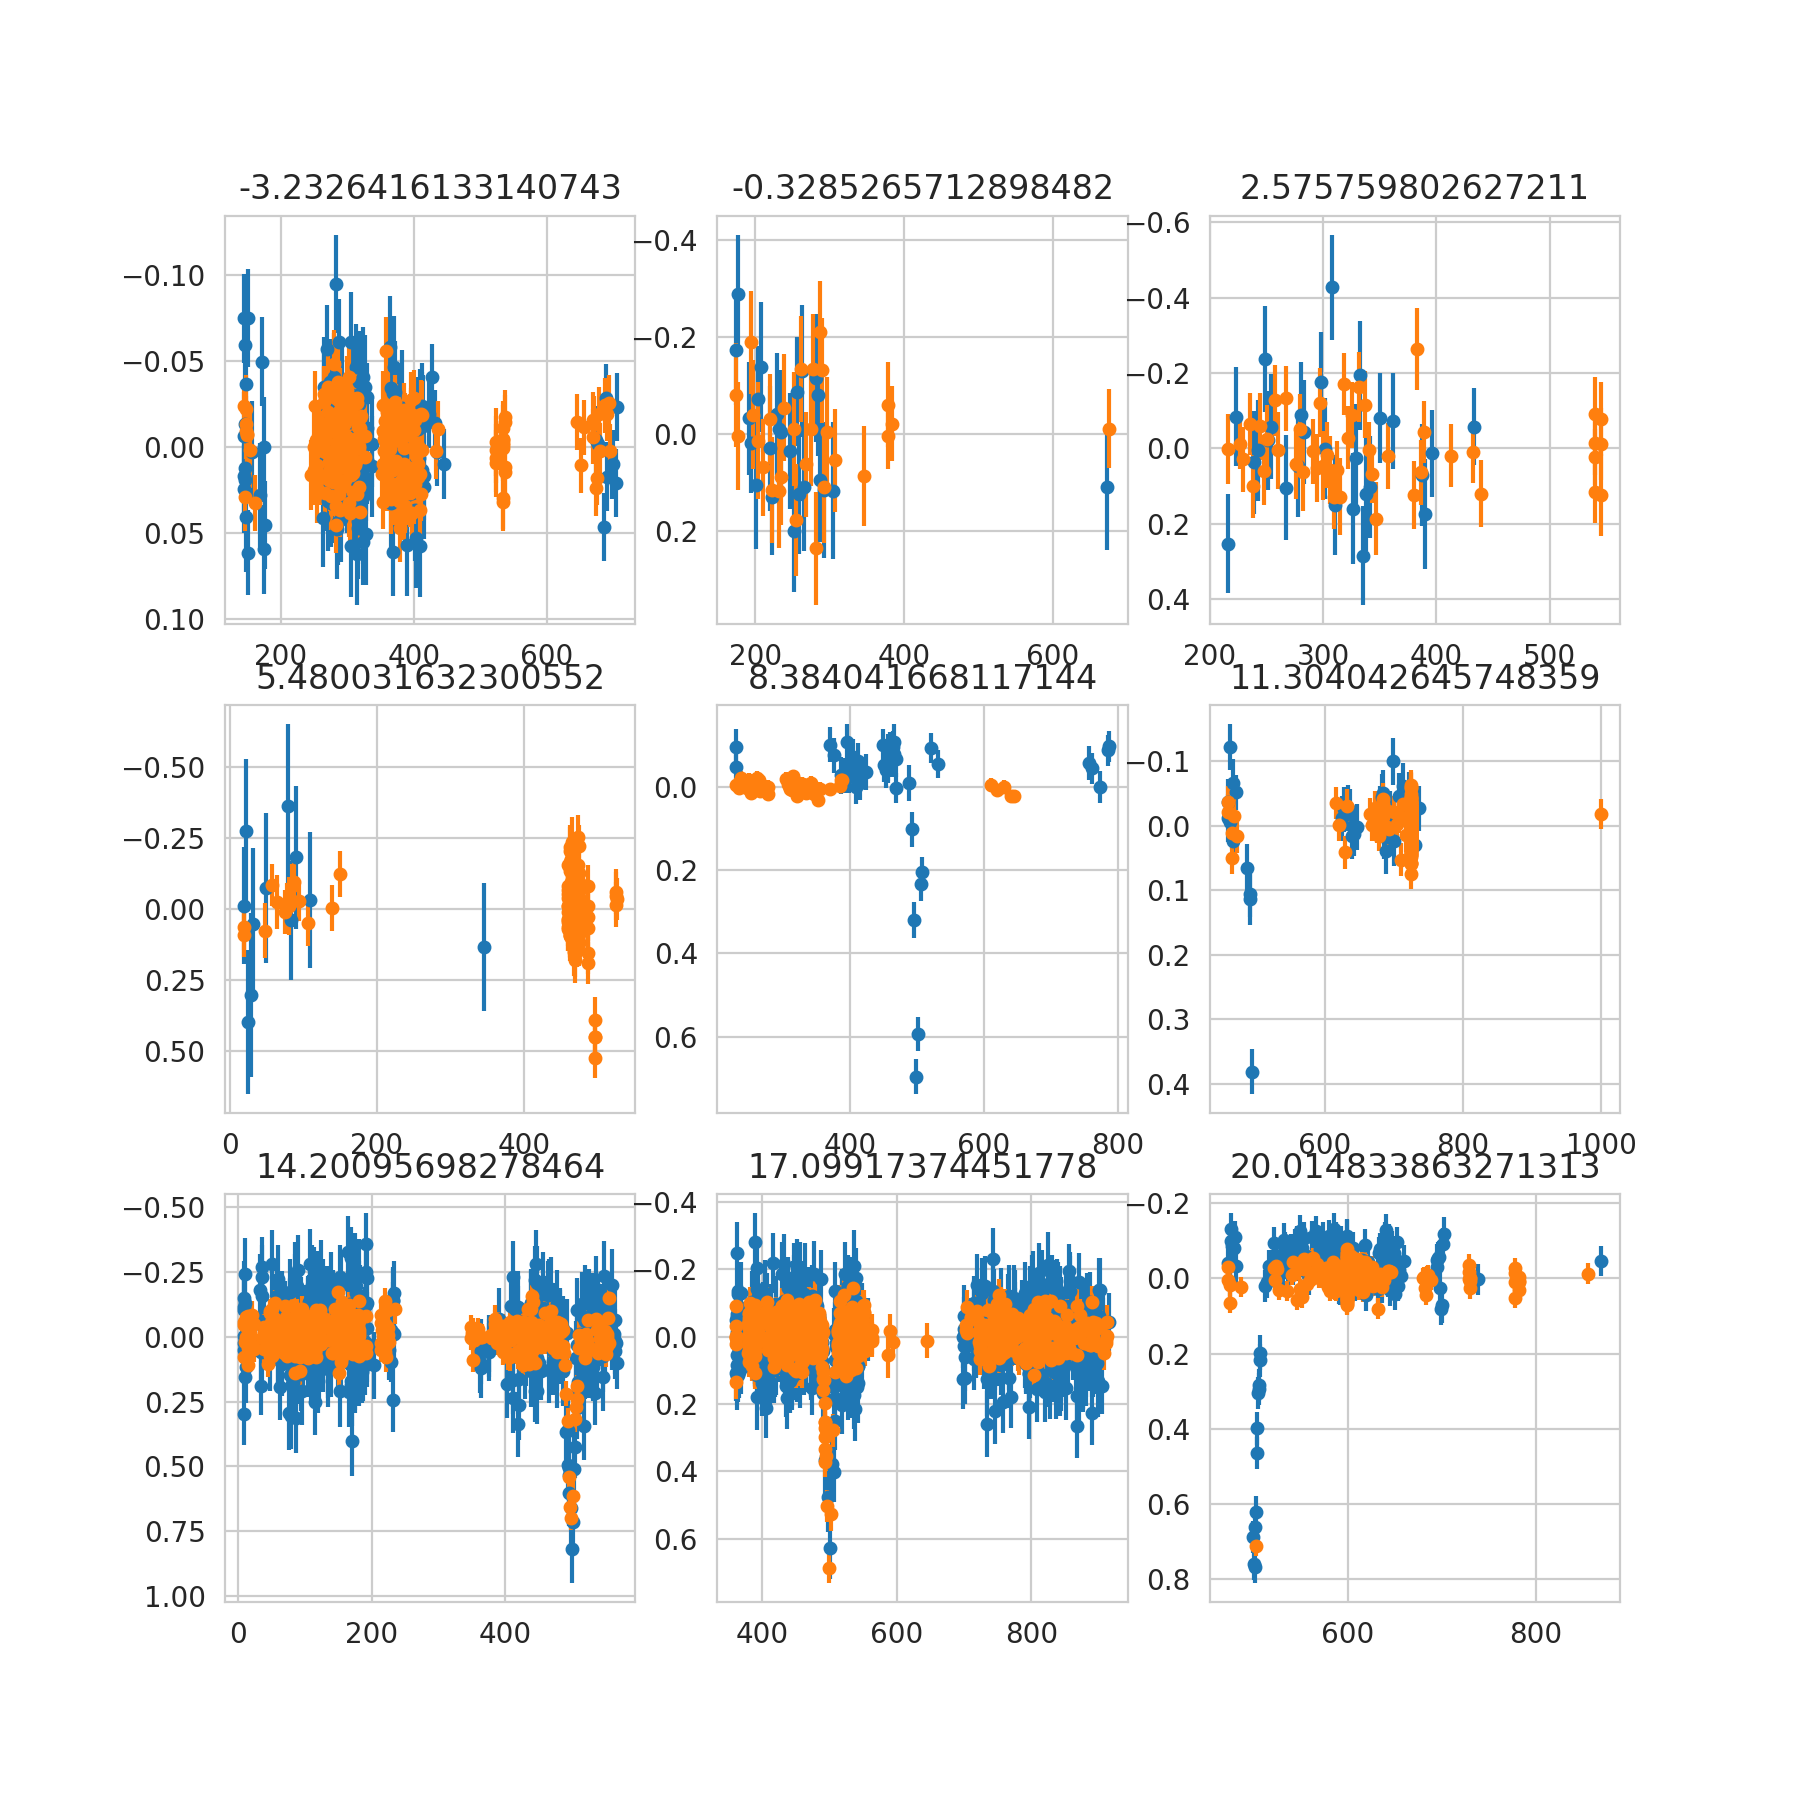

In [64]:
test_scores = np.linspace(np.min(sig_all), 20, 9)

fig, axes = plt.subplots(3, 3, figsize=(9,9))

axes = np.hstack(axes)

sig_all_sorted = np.sort(sig_all)
sig_all_sorted_idx = np.argsort(sig_all)

for i, ts in enumerate(test_scores):
    idx = sig_all_sorted_idx[sig_all_sorted.searchsorted(ts)]
    
    #sig_idx = np.where((sig_all >= ts) & (sig_all <= ts+1))[0]
    #print(sig_idx)
    res = res_all[idx]
    lc_all = lc_sim_all[idx]
    
    for lc in lc_all:
        axes[i].errorbar(lc.time, lc.flux-np.mean(lc.flux), yerr=lc.flux_err, fmt="o", markersize=4)
    
    axes[i].set_ylim(axes[i].get_ylim()[::-1])
    axes[i].set_title(res["significance"])



We are going to look for things with a significance > 15 to start with:

In [65]:
np.sum(sig_all > 15.0)

1893

There are 1893 out of 10000 dips that we'd find like this, which is not bad, though I'll admit that the dip is very deep:

In [66]:
sig_mask = (sig_all >= 15.0)

In [70]:
sig_idx = np.where(sig_mask == True)[0]